# Google Veo 3 Implemented from Scratch

[![Python 3.9+](https://img.shields.io/badge/python-3.9%2B-blue.svg)](https://www.python.org/downloads/release/python-390/) [![LinkedIn](https://img.shields.io/badge/LinkedIn-Profile-blue?logo=linkedin)](https://www.linkedin.com/in/fareed-khan-dev/) [![Medium](https://img.shields.io/badge/Medium-Blogs-black?logo=medium)](https://medium.com/@fareedkhandev) [![OpenAI](https://img.shields.io/badge/OpenAI-API-lightgrey)](https://openai.com/) [![Gemini](https://img.shields.io/badge/Gemini-API-brightgreen)](https://gemini.google.com/)

[Google Veo 3](https://deepmind.google/models/veo/) is a state-of-the-art text-to-video generation system capable of producing high-quality, high-resolution videos with audio from text prompts. It currently surpasses [OpenAI SORA](https://openai.com/sora/) and other similar models.

Google has published a [Veo 3 technical report](https://storage.googleapis.com/deepmind-media/veo/Veo-3-Tech-Report.pdf) and a [Model Card](https://storage.googleapis.com/deepmind-media/Model-Cards/Veo-3-Model-Card.pdf) detailing the architecture, training process, and more. This notebook offers a modular, step-by-step implementation of the Veo 3 model based on these resources.

The workflow covered in this notebook includes:
1. Data preprocessing and preparation
2. Building the Veo 3 model architecture
3. Model training
4. Inference
5. Model evaluation
6. Safety and ethical considerations

This notebook is intended for **students**, **researchers**, and anyone interested in understanding and implementing the Veo 3 system from scratch.

Make sure you have the basic knowledge of `Deep learning`, `PyTorch`, and `video processing` before diving into this notebook. To install the required packages, run:

```bash
pip install -r requirements.txt
```

## Table of Contents
- [What is JAX and Why it is Important?](#what-is-jax-and-why-it-is-important)
- [TPUs and ML Pathways](#tpus-and-ml-pathways)
- [Veo 3 High Level Overview](#veo-3-high-level-overview)
- [Data Preprocessing](#data-preprocessing)
  - [Raw Data Collection](#raw-data-collection)
  - [Semantic Deduplication](#semantic-deduplication)
  - [Unsafe Filtering](#unsafe-filtering)
  - [Quality and Compliance Filtering](#quality-and-compliance-filtering)
  - [Data Annotation](#data-annotation)
- [Veo 3 Model Architecture](#veo-3-model-architecture)
  - [Restructuring Data](#restructuring-data)
  - [Creating a Multi Modal Dataset](#creating-a-multi-modal-dataset)
  - [Video VAE (Video Variational Autoencoder)](#video-vae-video-variational-autoencoder)
  - [Audio VAE (Audio Variational Autoencoder)](#audio-vae-audio-variational-autoencoder)
  - [Conditional Encoder (CLIP instead of UL2)](#conditional-encoder-clip-instead-of-ul2)
  - [Transformers Block](#transformers-block)
  - [Timestep Embedding Generation](#timestep-embedding-generation)
  - [Joint Denoising Model (JDM)](#joint-denoising-model-jdm)
- [Training Veo 3 Model](#training-veo-3-model)
- [Inferencing Veo 3 with Cascading Reverse Diffusion](#inferencing-veo-3-with-cascading-reverse-diffusion)
- [Evaluation Strategy](#evaluation-strategy)
- [Responsible AI & Safety Integration (Synth ID)](#responsible-ai--safety-integration-synth-id)
- [Conclusion](#conclusion)

## What is JAX and Why it is Important?

AI model training involves a lot of matrix multiplications, and as training progresses, more memory gets consumed. Google stated in their [Veo 3 model card](https://storage.googleapis.com/deepmind-media/Model-Cards/Veo-3-Model-Card.pdf) that they used JAX.

[JAX](https://github.com/jax-ml/jax) is an open-source numerical computing library developed by Google. Its main purpose is high-performance numerical computation.

Let's see one of the benefits of JAX. We have this polynomial equation
$$x^2 + 3x + 2$$

For which we will compare the execution time of a function implemented in `NumPy` and `JAX`.

First, we import the necessary libraries and create two functions:
1. using numpy, which is easy to understand and implement.
2. and using JAX you can see that we use `@jax.jit` which is used to compile the function for performance optimization.

In [2]:
# Import necessary libraries
import jax

# Define Numpy function
def f_np(x):
  return x**2 + 3*x + 2

# Define JAX function with JIT compilation
@jax.jit
def f_jax(x):
  return x**2 + 3*x + 2

Now we create a 10 Million element array and measure the execution time of both functions.

In [3]:
# Import additional libraries for performance measurement
import numpy as np
import time
import jax.numpy as jnp

# Create input arrays
x_np = np.arange(10_000_000, dtype=np.float32)     # Create a large array for Numpy
x_jax = jnp.arange(10_000_000, dtype=jnp.float32)  # Create a large array for JAX

# Measure performance of Numpy function
start_np = time.time()
result_np = f_np(x_np)
time_np = time.time() - start_np

# Measure performance of JAX function
start_jax_first = time.time()
result_jax_first = f_jax(x_jax)
time_jax_first = time.time() - start_jax_first

# Measure performance of JAX function again to see the effect of JIT compilation
start_jax_second = time.time()
result_jax_second = f_jax(x_jax)
time_jax_second = time.time() - start_jax_second

# Print timing results
print(f"Numpy time: {time_np:.4f} seconds")
print(f"JAX first call time: {time_jax_first:.4f} seconds")
print(f"JAX second call time: {time_jax_second:.4f} seconds")

Numpy time: 0.0493 seconds
JAX first call time: 0.1019 seconds
JAX second call time: 0.0148 seconds


The first call to the JAX function is slower due to JIT compilation, but subsequent calls are significantly faster. This is **super important for performance in large-scale computations** as it avoids the overhead of compilation after the first call.

Moreover, JAX also supports reverse-mode differentiation (a.k.a. backpropagation) via `jax.grad` and many other advanced features like automatic vectorization and parallelization, which can further enhance performance for complex computations.

JAX does support plenty of training components but for our implementation, we will use PyTorch tensors and NumPy arrays to keep the code clean and understandable.

Learn more in the [JAX documentation](https://jax.readthedocs.io/en/latest/).

## TPUs and ML Pathways

![Compute Difference](images/compute_diff.png)

`OpenAI` and `Meta` typically use NVIDIA GPUs for training while [Google always favors TPUs](https://cloud.google.com/tpu?e=48754805&hl=en). They did the same for Veo 3 training and for many other models. By using TPUs, you cannot ignore [ML Pathways](https://blog.google/technology/ai/introducing-pathways-next-generation-ai-architecture/), which is another Google project designed to scale across TPU Pods, thousands of TPU chips without massive coordination overhead. It supports both data parallelism and model parallelism.
    
In the upcoming section, we will definitely see why this combination of `JAX`, `TPU`, and `ML Pathways` is being used, as the Veo 3 architecture is sparse and involves other models and components, it is not just a single model training. 

Learn more about TPUs in the [TPU documentation](https://cloud.google.com/tpu/docs) and about ML Pathways in the [Pathways blog post](https://blog.google/technology/ai/introducing-pathways-next-generation-ai-architecture/).

## Veo 3 High Level Overview

Let's take a look at the [Veo 3 high level architecture](https://storage.googleapis.com/deepmind-media/veo/Veo-3-Tech-Report.pdf) provided by Google:

[![Veo 3 Architecture](images/veo3_system.png)](https://storage.googleapis.com/deepmind-media/veo/Veo-3-Tech-Report.pdf)

So the training process starts ...

1. from encoding the input prompts, starting with a text prompt that is processed by a `UL2 encoder` to create a semantic embedding. Optionally, an image prompt can be included and encoded to enrich the input.

2. These embeddings are combined into an embedded prompt, which serves as conditioning input. At the same time, a noisy compressed video is initialized to simulate the generation space for training the model.

3. Next, a latent diffusion model learns to denoise this compressed video using the embedded prompt as guidance, gradually producing a refined compressed video.
   
4. This output is then passed through a decoder that reconstructs the full resolution video, such as a clear 1080p timelapse of a sunflower blooming.

But this high level diagram is a bit less informative and **hides the details of the components** involved in the training, preprocessing and safety measures. We are going to create our own diagram to break down the Veo 3 architecture into its components using [Model Card](https://storage.googleapis.com/deepmind-media/Model-Cards/Veo-3-Model-Card.pdf) and [Technical Report](https://storage.googleapis.com/deepmind-media/veo/Veo-3-Tech-Report.pdf).

![Veo 3 Architecture](images/Group_33.png)

Let' break down the Veo 3 architecture into four phases:

1. **Preprocessing Phase**: This phase involves preparation and preprocessing of the input data.
2. **Training Phase**: This phase involves training the Veo 3 model using the preprocessed data.
3. **Evaluation Phase**: This phase involves evaluating the trained model on various metrics.

We will look at each of these phases in detail.

## Data Preprocessing

Phase 1 is our `Data Preprocessing Phase`, which is crucial for preparing the data before training the Veo 3 model. The goal is to create a high-quality, diverse, and safe dataset that can be used for training.

[![Veo 3 Preprocessing Phase](images/phase_1_preprocess.png)](https://storage.googleapis.com/deepmind-media/veo/Veo-3-Tech-Report.pdf)

They start ...

1. with collecting `raw data` from various sources, including YouTube, Google Search, and other platforms (e.g., a video of a bird feeding).
2. Next, they perform `semantic deduplication` to remove near-duplicate content and keep only diverse examples (e.g., keeping one clear bird image and removing similar ones).
3. Then, they apply `unsafe filtering` to eliminate harmful or inappropriate content (e.g., removing an image of an owl carrying prey).
4. After that, `quality and compliance filtering` is done to discard low-quality, blurry, or non-compliant data (e.g., a dark, unclear theater video).
5. Once cleaned, `captions` are generated using Gemini to accurately describe the content (e.g., “Timelapse of a common sunflower opening”).

Finally, the result is a high-quality, safe, and labeled dataset ready for training the model.

Let's import all the necessary libraries that we will use in the data preprocessing phase.

In [15]:
# Google Generative AI SDK
import google.generativeai as genai  

# Progress bar utility
from tqdm import tqdm  

# File system operations
import os  

# Plotting and image display
import matplotlib.pyplot as plt  
import matplotlib.image as mpimg  

# Pickle for loading/saving Python objects
import pickle  

# Parallel processing utilities
from concurrent.futures import ThreadPoolExecutor, as_completed  

# Encoding/decoding utilities
import base64  

# OpenAI API
from openai import OpenAI  

# Computer vision library
import cv2

# Request handling
import requests

#### Raw Data Collection

The very first step is to collect raw data, which includes videos and images. Though there are tons of large Hugging Face datasets available, we are creating a learning project. For that, we can focus on [Pexels](https://www.pexels.com/) free content to randomly fetch videos and save them locally.

Veo 3 is trained on vast amounts of data, capturing a diverse range of objects and scenarios. For our case, we are targeting specific categories like nature, animals, and urban scenes. So, let’s define the categories we will use to fetch videos from Pexels.

In [ ]:
search_queries = [
    'cats',           # 🐱 animals
    'people walking', # 🚶‍♀️ humans / activity
    'cars',           # 🚗 vehicles / objects
    'hunting',        # 🏹 activity / nature
]

We are targeting a limited set of queries. Next, we need to define certain parameters, as we are using the Pexels API to fetch raw data. You can get your own free API key (commercial use allowed) from [Pexels](https://www.pexels.com/api/) and set it in the `PEXELS_API_KEY` variable.

In [ ]:
PEXELS_API_KEY = 'YOUR_PEXELS_API_KEY'  # Replace with your Pexels API key
per_page = 10 # Number of results per query
orientation = 'landscape' # Preferred video orientation (laptop, desktop, etc.)
size = 'small' # HD quality videos

So, based on our search queries and other parameters, we should have around `40 videos in total (4 categories × 10 videos each)`. The orientation is landscape (focusing on laptop/desktop), and the size is small (HD quality).

We can now use a simple loop to iterate through the search queries, fetch videos from the Pexels API, and download them to a local directory.

In [ ]:
# Create directory for downloaded videos and set up headers for API requests
os.makedirs('pexels_videos', exist_ok=True)
headers = {'Authorization': PEXELS_API_KEY}

total_videos_downloaded = 0  # Initialize counter for total videos downloaded

# Download videos for each search query
for q in search_queries:
    # Search for videos using Pexels API
    r = requests.get('https://api.pexels.com/videos/search',
                     headers=headers,
                     params={'query': q, 'per_page': per_page, 'orientation': orientation, 'size': size})
    
    # Download each video from search results
    for i, v in enumerate(r.json().get('videos', []), 1):
        
        # Get highest quality video file
        f = max(v['video_files'], key=lambda x: x['width'])
        out = f'pexels_videos/{q.replace(" ", "_")}_{i}.mp4'
        
        # Download and save video file
        with requests.get(f['link'], stream=True) as s, open(out, 'wb') as o:
            for chunk in s.iter_content(8192):
                o.write(chunk)
        
        total_videos_downloaded += 1  # Increment counter

print(f"Total videos downloaded: {total_videos_downloaded}")

Total videos downloaded: 40


Yup, we now have our raw data (40 videos) ready. We can move on to the next step, which is semantic deduplication, just as Google performs after obtaining their raw data.

#### Semantic Deduplication

Semantic deduplication is the process of identifying and removing duplicate content from a dataset, ensuring that each piece of information is unique. This is especially important when working with petabyte-scale datasets, as it helps avoid wasting storage space. This is the first step that `Google` performs after collecting their raw data.

Though we only have 40 videos, deduplication is still important here. Let's visualize this approach first and then implement it.

![Semantic Deduplication](images/semantic_deduplicate.png)

The process starts with ...

1. Instead of looking at every frame of the video, we extract the first, middle, and last frames from each video.
2. We annotate those frames using a multimodal model (Gemini, GPT, Claude, etc.) to get a description of each frame.
3. Then, we compare the descriptions of the frames to identify duplicates.

Processing every frame of the video is a very expensive operation, especially when we have a large dataset. That's why we only extract three frames from each video.

We first need to extract frames from the videos. So let's create a function to extract the first, middle, and last frames from each video.

In [ ]:
def extract_key_frames(video_path, output_dir):
    cap = cv2.VideoCapture(video_path)  # Open video file
    if not cap.isOpened():
        print(f"Failed to open {video_path}")
        return []

    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))  # Get total frame count
    indices = [0, frame_count // 2, frame_count - 1]  # Indices for key frames
    frame_paths = []

    for i, idx in enumerate(indices):
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx)  # Set frame position
        ret, frame = cap.read()  # Read frame
        if ret:
            out_path = os.path.join(
                output_dir,
                f"{os.path.basename(video_path).split('.')[0]}_frame_{i+1}.png"
            )  # Output path for frame
            cv2.imwrite(out_path, frame)  # Save frame as PNG
            frame_paths.append(out_path)  # Add path to list

    cap.release()  # Release video capture
    return frame_paths  # Return list of saved frame paths

Let's run the function to extract key frames from downloaded videos

In [ ]:
os.makedirs('pexels_frames', exist_ok=True)  # Create directory for frames if it doesn't exist

# Get list of all downloaded video files
video_files = [os.path.join('pexels_videos', f) for f in os.listdir('pexels_videos') if f.endswith('.mp4')]
all_frame_paths = {}  # Dictionary to store extracted frame paths for each video

# Use tqdm to show progress
for video in tqdm(video_files, desc="Extracting key frames"):
    frames = extract_key_frames(video, 'pexels_frames')  # Extract key frames from video
    all_frame_paths[video] = frames  # Store frame paths

print("Extracted key frames for all videos.")

Extracting key frames:   0%|          | 0/40 [00:00<?, ?it/s]

Extracting key frames: 100%|██████████| 40/40 [01:42<00:00,  2.55s/it]

Extracted key frames for all videos.


Now that our key frames are extracted, let's print one video and its key frames to verify the extraction process.

Sample video: pexels_videos\cars_1.mp4
Extracted key frames:


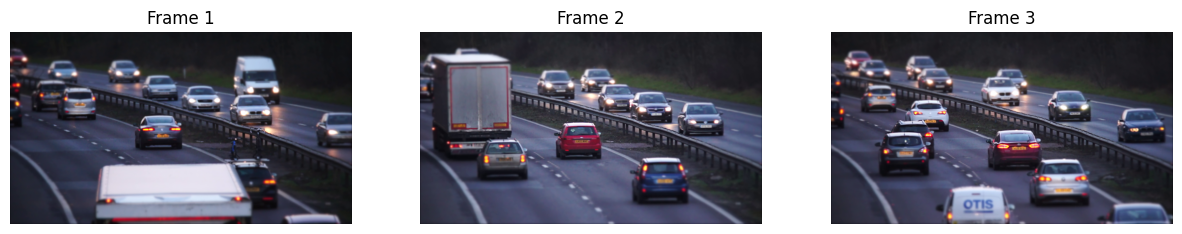

In [ ]:
# Pick a sample video and its frames
sample_video = video_files[0]
sample_frames = all_frame_paths[sample_video]

print(f"Sample video: {sample_video}")
print("Extracted key frames:")

plt.figure(figsize=(15, 5))
for i, frame_path in enumerate(sample_frames):
    img = mpimg.imread(frame_path)
    plt.subplot(1, 3, i + 1)
    plt.imshow(img)
    plt.title(f"Frame {i + 1}")
    plt.axis('off')
plt.show()

Next, we need to transform these frames into meaningful text representations so they can be used for deduplication and similarity checks. I will use the open-source LLM under the OpenAI API module instead of Gemini to make it easier to replicate the code, as Ollama and many other providers support it.

I am using the `Mistral-24B vision` model for image processing.

In [ ]:
client = OpenAI(
    base_url="https://api.studio.nebius.com/v1/",
    api_key="YOUR_LLM_PROVIDER_API_KEY"  # Replace with your OpenAI API key or any other API provider key (I am using Nebius AI)
)

In [10]:
# Encode image file to base64 string
def encode_image_to_base64(image_path):
    with open(image_path, "rb") as img_file:
        return base64.b64encode(img_file.read()).decode('utf-8')

# Get a concise scene description for a frame using Nebius API
def describe_frame(image_b64):
    response = client.chat.completions.create(
        model="mistralai/Mistral-Small-3.1-24B-Instruct-2503",
        messages=[
            {"role": "system", "content": "You generate concise scene descriptions for video frames."},
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": "Describe the scene in this frame in one line."},
                    {"type": "image_url", "image_url": {"url": f"data:image/png;base64,{image_b64}"}}
                ]
            }
        ]
    )
    return response.choices[0].message.content.strip()

Let's run the scene description and store it in a dictionary

In [ ]:
# Generate scene descriptions for each video's key frames with progress bar
video_descriptions = {}

for video, frames in tqdm(all_frame_paths.items(), desc="Describing frames"):
    descriptions = []
    for frame in frames:
        img_b64 = encode_image_to_base64(frame)
        desc = describe_frame(img_b64)
        descriptions.append(desc)
    video_descriptions[video] = descriptions

Describing frames: 100%|██████████| 40/40 [10:30<00:00, 15.77s/it]


Take a look at the descriptions for the first video

In [4]:
video_descriptions['pexels_videos\\cars_1.mp4']

['A congested multi-lane highway filled with various vehicles traveling in both directions under dim lighting, perhaps during dawn or dusk.',
 'Heavy traffic flows on a rainy highway at dusk with multiple cars and a truck.',
 'A busy, multi-lane highway filled with various cars during dusk or dawn, with an "OTIS" mobile vehicle inspection sign prominently displayed in the foreground.']

It's time to compare to perform the semantic deduplication of the video descriptions. We can futher embedd the descriptions using a `embedding model` and then use a cosine similarity metric to find duplicates based on a certain threshold.

But LLMs can also be used to perform semantic deduplication as they can understand the context and meaning of the descriptions in a human-like manner, so let's use a llm to perform the semantic deduplication of the video descriptions.

In [ ]:
# Define the prompt template where two video descriptions are compared
compare_prompt_template = """
Compare the two videos based on their key frame descriptions.
Respond 'Yes' if they are near-duplicates, 'No' if different.

Video 1:
{desc1}

Video 2:
{desc2}

Is Video 2 a semantic duplicate of Video 1?
"""

Similar to previous LLM calls, we will use the `LLaMA-3.3-70B` model to perform semantic deduplication of the video descriptions using a comparison function.

In [16]:
# Use LLM to compare two videos' scene descriptions for semantic deduplication
def compare_descriptions(desc1, desc2):
    """
    Returns 'Yes' if videos are semantic duplicates, 'No' otherwise.
    """

    response = client.chat.completions.create(
        model="meta-llama/Llama-3.3-70B-Instruct",
        max_tokens=10,
        temperature=0,
        messages=[
            {"role": "system", "content": "Answer strictly Yes or No."},
            {"role": "user", "content": compare_prompt_template.format(
                desc1=desc1,
                desc2=desc2
            )}
        ]
    )
    return response.choices[0].message.content.strip()


We need to use parallel processing to speed up the pairwise comparison of video descriptions, otherwise it will take too long to compare all pairs sequentially. We'll use `concurrent.futures` for this purpose, along with `tqdm` for progress tracking.

In [ ]:
# Prepare video list and names for pairwise comparison
video_list = list(video_descriptions.keys())
video_names = [os.path.basename(v) for v in video_list]
n = len(video_list)

# Build all unique video pairs (including self-pairs)
pairs = [(i, j) for i in range(n) for j in range(i, n)]

# Function to compare two videos using their scene descriptions
def compare_pair(i, j):
    vid1 = video_list[i]
    vid2 = video_list[j]
    if i == j:
        return (video_names[i], video_names[j], "Self")
    
    desc1_text = "\n".join([f"Frame {k+1}: {d}" for k, d in enumerate(video_descriptions[vid1])])
    desc2_text = "\n".join([f"Frame {k+1}: {d}" for k, d in enumerate(video_descriptions[vid2])])
    
    result = compare_descriptions(desc1_text, desc2_text)
    return (video_names[i], video_names[j], result)

# Run pairwise comparisons in parallel and collect results
results = []
with ThreadPoolExecutor(max_workers=10) as executor:  # adjust max_workers as needed
    futures = {executor.submit(compare_pair, i, j): (i, j) for i, j in pairs}
    for f in tqdm(as_completed(futures), total=len(futures), desc="Comparing pairs"):
        results.append(f.result())

Comparing pairs: 100%|██████████| 820/820 [00:40<00:00, 20.44it/s]


Now that we have performed pairwise comparisons, we can analyze the results to identify duplicates.

In [23]:
# check if any pairs are duplicates
[r for r in results if r[2] == "Yes"]

[]

So, we have successfully compared video pairs based on their scene descriptions using an LLM, identifying potential duplicates. The results show that there are no pairs considered semantic duplicates based on the descriptions provided. So no need to remove any videos at this stage.

Next, we need to move on to the next step, which is to create a harmful content filtering system.

#### Unsafe Filtering

Like in semantic deduplication, we divide the video into 3 key frames (First, Middle, Last) and merge their descriptions into a single text. This information gives us a high-level overview of what is happening in the video. It can be used to filter out harmful content.

Though we could further divide the videos into more key frames, such as 5 to 7, for better accuracy, this would increase the processing cost. The current approach is a good balance between cost and accuracy.

We are going to use this information to filter out harmful content. Let's visualize this first.

![Unsafe Filtering](images/unsafe_filtering.png)

The process starts with ...
1. Extracting the first, middle, and last frames from each video. (which we already did)
2. Generating scene descriptions for each key frame using a multimodal model (which we already did).
3. Identify predefined harmful content categories specific scenes based (e.g., weapons, blood, etc.) and check if the scene descriptions contain any of these pre-defined categories.


Let's define the harmful content categories based scene descriptions. We will use a simple list of categories for this example, but in a real-world scenario, you would want to use a more comprehensive list.

In [6]:
# Define harmful scenes to filter out
harmful_scenes = ["man holding a gun and pointing it somewhere", "blood on the ground", "people fighting"]

# Or if you are targeting only categories of harmful content
# harmful_categories = ["violence", "weapons", "blood", "fighting"]

So, we have defined our harmful content. We could also directly use a harmful objects-based unsafe filtering approach, but this might lead to removing non-harmful content.

For example, if a knife is used to cut a fruit, but you include "knife" in the harmful objects list, it will remove the video. Therefore, we will use the scene description-based approach to filter out harmful content, which is more accurate and less prone to false positives.

Let' create a function to filter out harmful content, We’ll merge the frame descriptions and check if any harmful keyword appears using LLM.

We are using the `LLaMA-3.3-70B` model to perform unsafe filtering of the video descriptions using a comparison function.

In [9]:
def classify_harmfulness(descriptions):
    prompt = f"""
    You are given descriptions of three key frames from a video. 
    Check if any of the following harmful scenes (or anything very close to them) are present in the descriptions:

    Harmful scenes:
    {chr(10).join(f"- {scene}" for scene in harmful_scenes)}

    Frame descriptions:
    {chr(10).join([f"Frame {i+1}: {desc}" for i, desc in enumerate(descriptions)])}

    If any harmful scene or something very similar is present, respond strictly with 'Harmful'. Otherwise, respond strictly with 'Safe'.
    """
    response = client.chat.completions.create(
        model="meta-llama/Llama-3.3-70B-Instruct",
        max_tokens=10,
        temperature=0,
        messages=[
            {"role": "system", "content": "Answer strictly Safe or Harmful."},
            {"role": "user", "content": prompt}
        ]
    )
    return response.choices[0].message.content.strip()

Similar to the deduplication step, we can use parallel processing to classify harmful content in the video descriptions. Let's do that.

In [ ]:
harmful_videos_llm = []

with ThreadPoolExecutor(max_workers=10) as executor:
    futures = {
        executor.submit(classify_harmfulness, descriptions): video
        for video, descriptions in video_descriptions.items()
    }
    for future in tqdm(as_completed(futures), total=len(futures), desc="Classifying harmful content"):
        video = futures[future]
        result = future.result()
        if result == "Harmful":
            harmful_videos_llm.append(video)

# Total harmful videos identified by LLM
print(f"Total harmful videos identified by LLM: {len(harmful_videos_llm)}")

Classifying harmful content: 100%|██████████| 40/40 [00:03<00:00, 11.18it/s]

Total harmful videos identified by LLM: 3


So, we have identified `3 videos` that contain harmful content based on the scene descriptions. Let's print their IDs

In [11]:
harmful_videos_llm

['pexels_videos\\hunting_1.mp4',
 'pexels_videos\\hunting_4.mp4',
 'pexels_videos\\hunting_9.mp4']

As expected, if you remember when we downloaded videos, we had a search query for "hunting". and there is a high chance that some of the videos contain hunting scenes, which can be considered harmful by some people. Let's print one of the harmful videos to see its description:

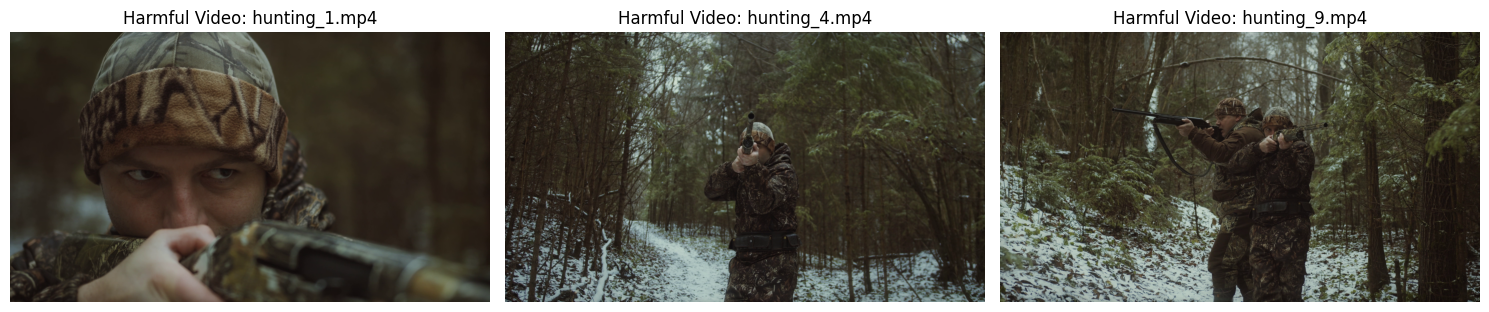

In [9]:
# Plot the first frame of each harmful video detected by the LLM
n = len(harmful_videos_llm)
fig, axes = plt.subplots(1, n, figsize=(5 * n, 5))

if n == 1:
    axes = [axes]

# Display the first frame for each harmful video
for ax, video in zip(axes, harmful_videos_llm):
    frames = all_frame_paths[video]
    if frames:
        img = mpimg.imread(frames[0])
        ax.imshow(img)
        ax.set_title(f"Harmful Video: {os.path.basename(video)}")
        ax.axis('off')
    else:
        ax.set_visible(False)

plt.tight_layout()
plt.show()

These videos are different, though they are from the same creators. Our LLM correctly identified them as harmful because our harmful scenes list does include `man holding a gun and pointing it somewhere.` Let's remove these videos from our dataset.

In [ ]:
for video in harmful_videos_llm:
    try:
        os.remove(video)  # Remove the video file
        print(f"Removed harmful video: {video}")
    except Exception as e:
        print(f"Error removing {video}: {e}")  # Handle any errors during removal

Removed harmful video: pexels_videos\hunting_1.mp4
Removed harmful video: pexels_videos\hunting_4.mp4
Removed harmful video: pexels_videos\hunting_9.mp4



Now that we have performed unsafe filtering, we can move on to the next step, which is quality and compliance filtering.

#### Quality and Compliance Filtering

Quality and compliance filtering is last second stage of the preprocessing phase, where we further anaylze and filter the data based on certain measures on our requirements. For example if we our target is to create a high-quality video dataset, we need to filter out low-quality videos based on certain criteria (eg. removing blurry videos, videos with low resolution, etc.).

Or if we are targeting a specific type of content, we need to filter out videos that do not comply with our requirements (eg. Famous people, celebrities, etc.).

Let's visualize this first.

![Quality and Compliance Filtering](images/quality_and_compliance.png)

The process starts with ...
1. Extracting the first, middle, and last frames from each video (which we already did).
2. Define the specific quality and compliance criteria based on our requirements (e.g., containing car license plates, famous people, blurry videos, etc.).
3. Identify predefined quality and compliance criteria based on scene descriptions and check if the scene descriptions contain any of these pre-defined criteria.

Similar to the unsafe filtering step, we can focus on multiple key frames to determine the quality, but we will stick to the first, middle, and last frames for simplicity. Let's define our simple quality criteria, but in a real-world scenario like `Veo 3`, you would want to use a more comprehensive list.

In [27]:
# We are focusing on Blurry, and Poor lighting as quality compliance issues
quality_compliance = [
    "Blurry: The video is so out of focus that the primary objects or subjects cannot be clearly seen or identified.",
    "Poor lighting: The video is too dark, too bright, or has uneven lighting, making it difficult to see or recognize key objects or actions."
]

We need to define a function, check_frame_quality, that uses a multimodal LLM to classify the quality of each frame. We are going to use the `Mistral 24B` model for this purpose.

In [28]:
def check_frame_quality(image_b64):
    issues = ", ".join(quality_compliance)
    response = client.chat.completions.create(
        model="mistralai/Mistral-Small-3.1-24B-Instruct-2503",
        messages=[
            {"role": "system", "content": (
                f"You are an expert in video quality assessment. "
                f"If the frame has {issues}, reply 'Non-compliant'. Else reply 'Compliant'."
            )},
            {"role": "user", "content": [
                {"type": "text", "text": (
                    f"Does this frame have {issues}? Reply 'Compliant' or 'Non-compliant'."
                )},
                {"type": "image_url", "image_url": {"url": f"data:image/png;base64,{image_b64}"}}
            ]}
        ],
        max_tokens=10,
        temperature=0
    )
    return response.choices[0].message.content.strip()

We are focusing on only middle frames for quality compliance checks, so let's create a function to extract the middle frame from each video.

In [29]:
def classify_middle_frame(video_path, frames):
    # Try to check the quality of the middle frame (frame 2)
    try:
        # Ensure frames list is not empty and has at least 2 elements (index 1)
        if frames and len(frames) > 1:
            image_b64 = encode_image_to_base64(frames[1])  # Encode middle frame to base64
            # Return video path if frame is non-compliant
            return video_path if check_frame_quality(image_b64) == "Non-compliant" else None
        else:
            # If frames list is empty or too short, mark as non-compliant
            return video_path
    except Exception as e:
        print(f"Error processing {video_path}: {e}")
        # On error, mark as non-compliant for safety
        return video_path

To avoid a long processing time, we will be using multithreading here also.

In [30]:
# Non compliant videos list
non_compliant_videos = []

# Use ThreadPoolExecutor to classify middle frames in parallel
with ThreadPoolExecutor(max_workers=10) as executor:
    # Create a dictionary to map futures to video paths for easier error tracking if needed
    future_to_video = {executor.submit(classify_middle_frame, v, f): v for v, f in all_frame_paths.items() if v not in harmful_videos_llm}
    
    # Use tqdm for progress bar
    for future in tqdm(as_completed(future_to_video), total=len(future_to_video), desc="Checking frame quality"):
        result = future.result()
        if result:
            non_compliant_videos.append(result)

print(f"Total non-compliant videos found: {len(non_compliant_videos)}")

Checking frame quality: 100%|██████████| 37/37 [01:41<00:00,  2.75s/it]

Total non-compliant videos found: 8


So, we got total 8 videos that are non-compliant based on the middle frame quality check. let's visualize the middle frame of one of them to see the issue.

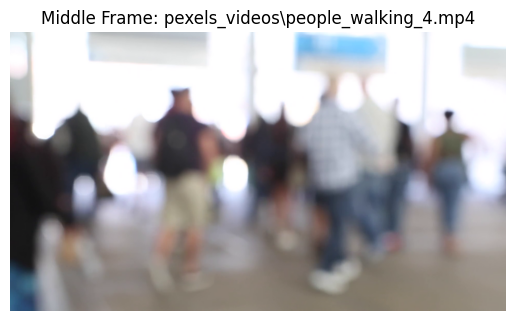

In [ ]:
# Pick the random non-compliant video
video_path = non_compliant_videos[6]
middle_frame_path = all_frame_paths[video_path][1]  # Middle frame is at index 1

img = mpimg.imread(middle_frame_path)
plt.imshow(img)
plt.title(f"Middle Frame: {video_path}")
plt.axis('off')
plt.show()

This is indeed a blurry frame, and our approach has classified it correctly as non-compliant. Now let's remove these videos from our dataset.

In [ ]:
for video in non_compliant_videos:
    try:
        os.remove(video)  # Remove the video file
        print(f"Removed non-compliant video: {video}")
    except Exception as e:
        print(f"Error removing {video}: {e}")  # Handle any errors during removal

Removed non-compliant video: pexels_videos\cars_6.mp4
Removed non-compliant video: pexels_videos\cats_10.mp4
Removed non-compliant video: pexels_videos\cars_1.mp4
Removed non-compliant video: pexels_videos\cars_8.mp4
Removed non-compliant video: pexels_videos\people_walking_1.mp4
Removed non-compliant video: pexels_videos\hunting_2.mp4
Removed non-compliant video: pexels_videos\people_walking_4.mp4
Removed non-compliant video: pexels_videos\people_walking_7.mp4
Removed non-compliant video: pexels_videos\hunting_5.mp4


So, we have removed all the harmful and non-compliant videos from the dataset. Let's count the remaining videos.

In [ ]:
# Count the number of videos remaining after filtering
video_paths = [os.path.join('pexels_videos', f) for f in os.listdir('pexels_videos') if f.endswith('.mp4')]
print(f"Total remaining videos after filtering: {len(video_paths)}")

Total remaining videos after filtering: 28


Our training videos are of different lengths. We need to trim our training videos to a fixed length. `Veo 3` can generate videos up to 8 seconds long. For simplicity, we will trim all videos to `5` seconds.

This will help reduce the size of the dataset and also fix the issue of videos being too long for training, which would consume more time and resources.

Let's trim the videos to 5 seconds.

In [ ]:
# Function to trim videos to a specified duration (in seconds)
def trim_video(input_path, output_path, duration=5):
    # Open the input video file
    cap = cv2.VideoCapture(input_path)
    fps = cap.get(cv2.CAP_PROP_FPS)  # Get frames per second
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))  # Total number of frames in the video
    target_frames = int(fps * duration)  # Number of frames to keep for the specified duration

    # If the video is shorter than the target duration, skip trimming
    if total_frames < target_frames:
        print(f"Video {input_path} is shorter than {duration} seconds. Skipping.")
        cap.release()
        return

    # Set up the video writer for the output trimmed video
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (int(cap.get(3)), int(cap.get(4))))

    # Write frames up to the target duration
    for _ in range(target_frames):
        ret, frame = cap.read()
        if not ret:
            break
        out.write(frame)

    # Release resources
    cap.release()
    out.release()

Let's run this function on all videos.

In [ ]:
os.makedirs('trimmed_videos', exist_ok=True)

def process_video(input_path):
    output_path = os.path.join('trimmed_videos', os.path.basename(input_path))
    trim_video(input_path, output_path, duration=5)

with ThreadPoolExecutor(max_workers=8) as executor:
    list(tqdm(executor.map(process_video, video_paths), total=len(video_paths), desc="Trimming videos"))

Trimming videos: 100%|██████████| 28/28 [01:15<00:00,  2.71s/it]


Now that we have trimmed the videos to 5 seconds and stored them in the `trimmed_videos` directory, we can perform an additional step: for example, we want to select only videos that are less than 20 MB in size. This can help us ensure that the videos are lightweight and suitable for further processing or sharing.

In [4]:
# get all trimmed video paths
trimmed_video_paths = [os.path.join('trimmed_videos', f) for f in os.listdir('trimmed_videos') if f.endswith('.mp4')]
print(f"Total trimmed videos: {len(trimmed_video_paths)}")

Total trimmed videos: 28


Let's perform this step to remove the bigger size videos and keep only the smaller ones.

In [ ]:
# Remove videos that are more than 20MB in size with progress bar
def remove_large_videos(video_paths, max_size_mb=20):
    for video in tqdm(video_paths, desc="Checking video sizes"):
        if os.path.getsize(video) > max_size_mb * 1024 * 1024:  # Convert MB to bytes
            try:
                os.remove(video)
                print(f"Removed large video: {video}")
            except Exception as e:
                print(f"Error removing {video}: {e}")

# Call the function to remove large videos
remove_large_videos(trimmed_video_paths, max_size_mb=20)

Checking video sizes: 100%|██████████| 28/28 [00:00<00:00, 587.12it/s]

Removed large video: trimmed_videos\cars_2.mp4
Removed large video: trimmed_videos\cars_3.mp4
Removed large video: trimmed_videos\cars_5.mp4
Removed large video: trimmed_videos\cats_7.mp4
Removed large video: trimmed_videos\hunting_7.mp4
Removed large video: trimmed_videos\people_walking_6.mp4


In [6]:
# get all trimmed video paths
trimmed_video_paths = [os.path.join('trimmed_videos', f) for f in os.listdir('trimmed_videos') if f.endswith('.mp4')]
print(f"Total trimmed videos: {len(trimmed_video_paths)}")

Total trimmed videos: 22


So, we have total `22` videos remaining after filtering out harmful and non-compliant videos. Now we are moving on to last step of the pipeline, which is to annotate the pre-processed videos.

#### Data Annotation

In `Veo 3` creation, previous steps such as unsafe filtering and more were done multiple times, and after that, the last stage of data preprocessing was performed. We tried to reduce costs in previous steps by using open-source models, but annotation strictly needs to be done by Gemini or other models which can understand videos.

![Data annotation](images/data_annotate.png)

Veo 3 training data preprocessing was also done multiple times, including annotation, which was performed using Gemini models. We are going to do the same. You can get your own free API key (commercial use allowed) from [Gemini](https://ai.google.dev/) and set it in the `GEMINI_API_KEY` variable.

In [ ]:
genai.configure(api_key="YOUR_GEMINI_API_KEY")  # Replace with your Gemini API key

model = genai.GenerativeModel("gemini-2.0-flash") # We are using Gemini 2.0 Flash model

Let's annotate the trimmed videos.

In [ ]:
video_annotations = []

# Iterate through each trimmed video and generate a summary annotation
for video_file_name in tqdm(trimmed_video_paths, desc="Annotating videos"):
    with open(video_file_name, 'rb') as f:
        video_bytes = f.read()
    try:
        # Use Gemini model to generate a 3-sentence summary for the video
        response = model.generate_content([
            {
                "mime_type": "video/mp4",
                "data": video_bytes
            },
            "Summarize the video in 3 sentences. Provide only the summary and nothing else."
        ])
        # Extract summary text from the response
        summary = response.text if hasattr(response, "text") else str(response)
    except Exception as e:
        # Handle errors and store the error message as summary
        summary = f"Error: {e}"
    # Append the annotation result to the list
    video_annotations.append({"video_path": video_file_name, "summary": summary})

Annotating videos: 100%|██████████| 22/22 [03:15<00:00,  8.90s/it]


In [19]:
video_annotations[0]

{'video_path': 'trimmed_videos\\cars_10.mp4',
 'summary': 'The video shows two cars drifting in a parking lot track marked with tires, with a crowd watching from a building in the background. The yellow car takes the initial lead but is overtaken by the dark colored car, which then drifts around the tires leaving smoke. The cars continue to drift around the track marked with tires.\n'}

We need to do some cleaning here like removing the "The video shows" prefix and ensuring the summary is concise.

In [ ]:
# Removing 'The video shows' prefix from summaries
for annotation in video_annotations:
    if annotation['summary'].startswith("The video shows"):
        annotation['summary'] = annotation['summary'][len("The video shows"):].strip()

# Display the first video annotation
video_annotations[0]

{'video_path': 'trimmed_videos\\cars_10.mp4',
 'summary': 'two cars drifting in a parking lot track marked with tires, with a crowd watching from a building in the background. The yellow car takes the initial lead but is overtaken by the dark colored car, which then drifts around the tires leaving smoke. The cars continue to drift around the track marked with tires.'}

Great, so far we have pre-processed the data according to `Veo 3` specifications, including deduplication, quality compliance checks, and generating concise annotations. However, we need to further restructure the data to match the expected format for Veo 3.

This step is part of training the Veo 3 model, which we will cover in the upcoming sections.

## Veo 3 Model Architecture

Phase 2 is our `Coding Veo 3 Architecture`. This is the most complex part of the Veo 3 project, where the architecture of the Veo 3 model is designed and implemented.

Veo 3 can generate high-quality videos using two types of inputs:

1. `Text prompts`: These are natural language descriptions of the desired video content, such as "A timelapse of a sunflower blooming."
2. `Image prompts + Text prompts`: These are a combination of an image and a text description, such as "A timelapse of a sunflower blooming" with an image of a sunflower.

Let's visualize it first.

![Phase 2: Coding Veo 3 Architecture](images/phase_2_veo3_architecture.png)

The process starts with:
1. Videos and audio are encoded using the `Video Encoder` and `Audio Encoder`, respectively.
2. Images and text are encoded using the [UL2](https://huggingface.co/google/ul2) encoder provided by Google.
3. The encoded video and audio, along with some noise, and the embedded images and text are passed to a joint denoiser backed by a transformer architecture.
4. The joint denoiser processes the inputs and generates a joint representation of the video and audio.

Let's implement these components step by step. But first we need to import the necessary libraries that will be used through this phase.

In [ ]:
import imageio  # For reading/writing images
from PIL import Image  # For image manipulation

import torch  # Core PyTorch library
import torch.nn as nn  # For neural network modules
import torch.nn.functional as F  # Functional API (e.g., activation functions)
import torch.optim as optim  # Optimizers (e.g., Adam, SGD)
from torch.optim.lr_scheduler import CosineAnnealingLR  # Learning rate scheduler
from torch.utils.data import Dataset, DataLoader  # For creating datasets and loading data
import torchaudio  # For audio processing

from torchvision import transforms  # For common image transformations

from diffusers import DDPMScheduler  # For diffusion models scheduling
from transformers import CLIPProcessor, CLIPModel  # For CLIP model and processor

from einops import rearrange  # For tensor reshaping and repetition

import numpy as np  # For numerical operations

import skimage.transform # For image transformations (e.g., resizing, cropping)

# Set computation device to GPU if available, otherwise CPU
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


#### Restructuring Data

In our data preprocessing step, you can see that our finalized dataset consists only of videos. However, for Veo 3, images can also be passed with text to generate videos. Additionally, audio is processed separately.

Therefore, we first need to separate everything properly. In short, we need to restructure our dataset to have a proper structure for each data type.

This is our target structure:

```bash
📁 dataset/
 ├── 📁 t2v_pairs/            # dir containing text to videos pairs training data
 │    ├── 📄 video_1.mp4      # video file
 │    ├── 📄 video_1.wav      # audio file (extracted from video_1.mp4)
 │    ├── 📄 video_1.txt      # text prompt or annotation for video_1.mp4
 │    └── ...
 └── 📁 i2v_pairs/            # dir containing image to videos pairs training data
      ├── 📄 image_1.jpg      # input image
      ├── 📄 video_1.mp4      # generated video file
      ├── 📄 video_1.wav      # audio file (extracted from video_1.mp4)
      └── ...
```

This step simply requires average Python coding skills. It is not necessary to display it here since it would take time to understand. I have combined the code in [transform_data.py](transform_data.py), which you can use to transform our trimmed videos data into the required `dataset/` directory as discussed above.

Now that we have `dataset/` dir ready, we further need to create a structure dataset variables based on paths of audios, images and videos. This will help us to easily access the data during training and inference.

we need to define directories which contains our pairs dataset

In [ ]:
# Paths
i2v_dir = 'dataset/i2v_pairs'
t2v_dir = 'dataset/t2v_pairs'

# Collect files
i2v_files = os.listdir(i2v_dir)
t2v_files = os.listdir(t2v_dir)

Let's first create our text to video pairs.

In [7]:
# Build T2V_INFO
t2v_info = []
t2v_videos = [f for f in t2v_files if f.endswith('.mp4')]

for idx, video_file in enumerate(t2v_videos, start=1):
    base_name = os.path.splitext(video_file)[0]
    audio_file = f"{base_name}.wav"
    
    # Find matching annotation
    annotation = next((a for a in video_annotations if a['video_path'].split('\\')[-1] == video_file), None)
    caption = annotation['summary'] if annotation else ''
    
    t2v_info.append({
        'id': f"t2v_{idx:03d}",
        'video_path': video_file,
        'audio_path': audio_file,
        'initial_caption': caption
    })


Similarly, we can create (image + text) to video pairs dataset

In [8]:
# Build I2V_INFO
i2v_info = []
i2v_images = [f for f in i2v_files if f.endswith('.jpg')]

for idx, image_file in enumerate(i2v_images, start=1):
    base_name = os.path.splitext(image_file)[0]
    video_file = f"{base_name}.mp4"
    audio_file = f"{base_name}.wav"
    
    # Find matching annotation
    annotation = next((a for a in video_annotations if a['video_path'].split('\\')[-1] == video_file), None)
    prompt = annotation['summary'] if annotation else ''
    
    i2v_info.append({
        'id': f"i2v_{idx:03d}",
        'image_path': image_file,
        'target_video_path': video_file,
        'target_audio_path': audio_file,
        'prompt': prompt
    })

Checking the total number of pairs

In [9]:
len(i2v_info), len(t2v_info)  # Check the lengths of the info lists

(5, 17)

Take a look at a sample pair of `I2V` and `T2V` pairs

In [10]:
i2v_info[0], t2v_info[0]  # Display the first entries of each info list

({'id': 'i2v_001',
  'image_path': 'cats_2.jpg',
  'target_video_path': 'cats_2.mp4',
  'target_audio_path': 'cats_2.wav',
  'prompt': 'An orange, fluffy kitten is playing with a small toy on a couch. It pounces and bats at the toy with its paws, appearing very playful and energetic. The couch has a patterned cover and is surrounded by pillows.\n'},
 {'id': 't2v_001',
  'video_path': 'cars_10.mp4',
  'audio_path': 'cars_10.wav',
  'initial_caption': 'two cars drifting in a parking lot track marked with tires, with a crowd watching from a building in the background. The yellow car takes the initial lead but is overtaken by the dark colored car, which then drifts around the tires leaving smoke. The cars continue to drift around the track marked with tires.'})

We need to transform our training data (`videos` + `audios` + `images`) into `tensors` which will be used for training the model, in simple terms, tensors are multi-dimensional arrays that can be processed and get improved during training. We will use the `torch` library to convert our data into tensors.

We need to create two functions: one for converting the video data into tensors and another for converting the audio data into tensors. While we are at it, we will also be declaring some variables that will be used later throughout the process.

In [19]:
# Base video frames (meaning the number of frames to extract from each video)
BASE_VIDEO_FRAMES = 16

# Function to preprocess video files into tensors
def preprocess_video(path, target_height, target_width):
    # Read video frames using imageio
    reader = imageio.get_reader(path, 'ffmpeg')
    frames = []
    for i, f in enumerate(reader):
        if i >= BASE_VIDEO_FRAMES:
            break
        # Resize each frame to (target_height, target_width) and convert to tensor (C, H, W)
        resized = skimage.transform.resize(f, (target_height, target_width), anti_aliasing=True)
        tensor = torch.from_numpy(resized).permute(2, 0, 1).float()
        frames.append(tensor)
    # Pad with black frames if not enough frames are present
    if len(frames) < BASE_VIDEO_FRAMES and frames:
        pad_frame = torch.zeros_like(frames[0])
        frames.extend([pad_frame] * (BASE_VIDEO_FRAMES - len(frames)))
    # Stack frames into a tensor of shape (C, T, H, W)
    return torch.stack(frames, dim=1) if frames else None


Now that we have defined the preprocessing for video with one key parameter, we can now define the preprocessing for audio files. with certain parameters that are specific to audio files.

In [20]:
# Audio parameters 
AUDIO_SAMPLE_RATE = 16000 # Standard sample rate for audio processing (meaning the number of samples per second)
AUDIO_DURATION_SEC = 2 # Duration of audio clips in seconds (meaning how long each audio clip should be)
AUDIO_SAMPLES = AUDIO_SAMPLE_RATE * AUDIO_DURATION_SEC # Total number of audio samples (meaning the total number of audio samples in the clip)

# This function preprocesses audio files to ensure they are in the correct format and length
def preprocess_audio(path):
    w, sr = torchaudio.load(path)
    # Keep only the first channel if multi-channel
    if w.shape[0] > 1:
        w = w[:1, :]
    # Resample if needed
    if sr != AUDIO_SAMPLE_RATE:
        w = torchaudio.transforms.Resample(sr, AUDIO_SAMPLE_RATE)(w)
    # Pad or trim to fixed length
    if w.shape[1] < AUDIO_SAMPLES:
        w = F.pad(w, (0, AUDIO_SAMPLES - w.shape[1]))
    else:
        w = w[:, :AUDIO_SAMPLES]
    # Normalize
    max_val = torch.max(torch.abs(w))
    if max_val > 0:
        w = w / max_val
    return w


So, our focus is onto two things, base video and upsampled video tensors for training. The base video tensor is the original video frames, while the upsampled video tensor is created by repeating the frames to match a target number of frames.

We also need to create two new functions that will be built on top of the previous existing functions, since we are handling images, videos, and audios at the same time. So let's do that now.

In [21]:
# Define constants for video dimensions
UPSAMPLED_VIDEO_HEIGHT = 64 # Height of the upsampled video frames (meaning the height of the video frames after upsampling)
UPSAMPLED_VIDEO_WIDTH = 64 # Width of the upsampled video frames (meaning the width of the video frames after upsampling)
BASE_VIDEO_HEIGHT = 32 # Height of the base video frames (meaning the height of the original video frames before upsampling)
BASE_VIDEO_WIDTH = 32 # Width of the base video frames (meaning the width of the original video frames before upsampling)

T2V_DATA_DIR = 'dataset/t2v_pairs' # Directory for T2V pairs (meaning the directory where the text-to-video pairs are stored)
I2V_DATA_DIR = 'dataset/i2v_pairs' # Directory for I2V pairs (meaning the directory where the image-to-video pairs are stored)

Now that we define parameters, let's code both the T2V and I2V datasets.

In [14]:
def load_i2v_item(info):
    # Load a base and upsampled version of the input image
    img_pil = Image.open(
        os.path.join(I2V_DATA_DIR, info['image_path'])
    ).convert('RGB')
    img_base = transforms.ToTensor()(
        img_pil.resize((BASE_VIDEO_WIDTH, BASE_VIDEO_HEIGHT))
    )
    img_upsampled = transforms.ToTensor()(
        img_pil.resize((UPSAMPLED_VIDEO_WIDTH, UPSAMPLED_VIDEO_HEIGHT))
    )

    # Preprocess target video at base and upsampled resolutions
    vid_base = preprocess_video(
        os.path.join(I2V_DATA_DIR, info['target_video_path']),
        BASE_VIDEO_HEIGHT, BASE_VIDEO_WIDTH
    )
    vid_upsampled = preprocess_video(
        os.path.join(I2V_DATA_DIR, info['target_video_path']),
        UPSAMPLED_VIDEO_HEIGHT, UPSAMPLED_VIDEO_WIDTH
    )

    # Preprocess target audio
    aud = preprocess_audio(
        os.path.join(I2V_DATA_DIR, info['target_audio_path'])
    )

    # Return a dictionary containing all modalities and metadata
    return {
        'modality': 'i2v',
        'input_image_base': img_base,
        'input_image_upsampled': img_upsampled,
        'target_video_base': vid_base,
        'target_video_upsampled': vid_upsampled,
        'target_audio': aud,
        'caption': info['prompt'],
        'id': info['id']
    }

And for T2V items ...

In [15]:
def load_t2v_item(info):
    base_vid = preprocess_video(
        os.path.join(T2V_DATA_DIR, info['video_path']),
        BASE_VIDEO_HEIGHT, BASE_VIDEO_WIDTH
    )
    upsampled_vid = preprocess_video(
        os.path.join(T2V_DATA_DIR, info['video_path']),
        UPSAMPLED_VIDEO_HEIGHT, UPSAMPLED_VIDEO_WIDTH
    )
    audio = preprocess_audio(
        os.path.join(T2V_DATA_DIR, info['audio_path'])
    )
    if base_vid is not None and upsampled_vid is not None and audio is not None:
        return {
            'modality': 't2v',
            'video_base': base_vid,
            'video_upsampled': upsampled_vid,
            'audio': audio,
            'caption': info['initial_caption'],
            'id': info['id']
        }
    return None

Finally, we are now ready to run the restructuring final step as we transform the data into a format suitable for training (tensors).

In [ ]:
# Load Text-to-Video (T2V) data:
# - For each entry in t2v_info, call load_t2v_item to preprocess video, audio, and caption.
# - Only keep non-None results.
t2v_data = [
    d for d in [
        load_t2v_item(i) for i in tqdm(t2v_info, desc="Loading T2V data")
    ] if d
]

# Load Image-to-Video (I2V) data:
# - For each entry in i2v_info, call load_i2v_item to preprocess image, video, audio, and prompt.
# - Only keep non-None results.
i2v_data = [
    d for d in [
        load_i2v_item(i) for i in tqdm(i2v_info, desc="Loading I2V data")
    ] if d
]

Loading I2V data: 100%|██████████| 2/2 [00:27<00:00, 13.93s/it]


Let's merge the updated tensors data into a single data variable

In [20]:
raw_data = t2v_data + i2v_data  # Combine both datasets

So, we have finally transformed our raw data into a format suitable for training. Before we proceed to the `Video` or `Audio` encoder, we need to create a `MultiModalDataset` class that will handle the data loading and batching for us. That class will contain all the transformed data in a structured way, allowing us to easily access the different modalities (video, audio, image, text) and their corresponding captions.

#### Creating a Multi Modal Dataset

Object-Oriented Programming (OOP) is the correct and suitable way to structure your training data, and this is exactly what we are doing here. We are going to create a class that will handle the data loading and processing for both T2V and I2V datasets.

In [22]:
BATCH_SIZE = 1  # Batch size for DataLoader (how many samples to process in one batch)

class MultiModalDataset(Dataset):
    def __init__(self, data_list):
        # Store the list of data samples (each sample is a dict for t2v or i2v)
        self.data = data_list

    def __len__(self):
        # Return the number of samples in the dataset
        return len(self.data)

    def __getitem__(self, idx):
        # Get the sample at the given index
        item = self.data[idx]
        # Use the caption (should be set in your data)
        caption_string = item['caption']

        if item['modality'] == 't2v':
            # For text-to-video: return video, audio, and a dummy image tensor
            return {
                'modality': 't2v',
                'video_base': item['video_base'],
                'video_upsampled': item['video_upsampled'],
                'audio': item['audio'],
                'raw_caption': caption_string,
                # Dummy image tensor (all zeros) for t2v, shape matches a single video frame
                'input_image_base': torch.zeros_like(item['video_base'][:, 0]),
            }
        else:  # For image-to-video
            return {
                'modality': 'i2v',
                'video_base': item['target_video_base'],
                'video_upsampled': item['target_video_upsampled'],
                'audio': item['target_audio'],
                'raw_caption': caption_string,
                # Use the actual input image tensor for i2v
                'input_image_base': item['input_image_base'],
            }

We can simple call this class `MultiModalDataset` on top of our raw data. This class will inherit from `torch.utils.data.Dataset`, which is a PyTorch class that provides a way to load and process data in batches.

In [23]:
# Create the dataset and dataloader for training
# - train_dataset: wraps the raw_data list using the MultiModalDataset class
# - train_dataloader: DataLoader for batching and shuffling during training
train_dataset = MultiModalDataset(raw_data)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
print(f"MultiModalDataset created with {len(train_dataset)} samples.")

MultiModalDataset created with 4 samples.


Great we can now proceed to code the actual architecture of the veo 3 model which consists of multiple components, including the video encoder, audio encoder, conditional encoder, and the joint denoiser and more.

#### Video VAE (Video Variational Autoencoder)

Great, so now that we have preprocessed our raw data and restructured it into a PyTorch Dataset which is essential for training a video generation model, we can move on to create the first model component: the Video Encoder.

A VAE (Variational Autoencoder) is a type of neural network architecture used for unsupervised learning tasks, particularly in generative models. It consists of two main components:
1. **Encoder**: Maps input data (such as images or videos) to a latent space representation.
2. **Decoder**: Maps the latent space representation back to the original data space, allowing for reconstruction of the input data.

Let's visualize this architecture (Source Wikipedia):

![Video VAE Architecture](images/vae_architecture.png)

It works like this ....

1. The encoder takes an input tensor and encodes it into a latent representation a latent vector which captures the important features of the input data (for example, the shape, color, and texture of an image or video frame). The encoder typically consists of convolutional layers that progressively downsample the input tensor while extracting features.
2. The decoder then takes this latent vector and reconstructs the original input data, typically using transposed convolutional layers to upsample the latent representation back to the original dimensions.

Let' code this `VideoVAE` along with some configurations for training.

In [24]:
VIDEO_LATENT_CHANNELS = 4 # Number of channels in the latent space for video (meaning the number of feature maps in the latent representation)

class VideoVAE(nn.Module):
    def __init__(self):
        super().__init__()
        # Encoder: Input shape (B, 3, F, H, W) -> Latent (B, C_lat, F/2, H/8, W/8)
        self.e = nn.Sequential(
            # First 3D conv: downsample F, H, W by 2, output channels 32
            nn.Conv3d(3, 32, kernel_size=3, stride=(2, 2, 2), padding=1), nn.SiLU(),
            # Second 3D conv: downsample H, W by 2, output channels 64
            nn.Conv3d(32, 64, kernel_size=3, stride=(1, 2, 2), padding=1), nn.SiLU(),
            # Third 3D conv: downsample H, W by 2, output channels 128
            nn.Conv3d(64, 128, kernel_size=3, stride=(1, 2, 2), padding=1), nn.SiLU(),
            # Final 3D conv: output latent channels, no downsampling
            nn.Conv3d(128, VIDEO_LATENT_CHANNELS, kernel_size=3, stride=1, padding=1)
        )
        # Decoder: Latent -> Output (reverse of encoder)
        self.d = nn.Sequential(
            # First transpose conv: keep shape, output channels 128
            nn.ConvTranspose3d(VIDEO_LATENT_CHANNELS, 128, kernel_size=3, stride=1, padding=1), nn.SiLU(),
            # Second transpose conv: upsample H, W by 2, output channels 64
            nn.ConvTranspose3d(128, 64, kernel_size=3, stride=(1, 2, 2), padding=1, output_padding=(0, 1, 1)), nn.SiLU(),
            # Third transpose conv: upsample H, W by 2, output channels 32
            nn.ConvTranspose3d(64, 32, kernel_size=3, stride=(1, 2, 2), padding=1, output_padding=(0, 1, 1)), nn.SiLU(),
            # Final transpose conv: upsample F, H, W by 2, output channels 3 (RGB)
            nn.ConvTranspose3d(32, 3, kernel_size=3, stride=(2, 2, 2), padding=1, output_padding=1), nn.Sigmoid()
        )

    def encode(self, x):
        # Pass input through encoder
        return self.e(x)

    def decode(self, x):
        # Pass latent through decoder
        return self.d(x)

Our `VideoVAE` contains an encoder that compresses a video into a latent representation and a decoder that reconstructs the video from this latent space. The encoder uses 3D convolutions to process the temporal dimension (frames) along with spatial dimensions (height and width), while the decoder uses transposed convolutions to upsample back to the original video shape.

Now that we coded for VAE for video, `Veo 3` can create audios too, so let's create a simple VAE for audio as well.

#### Audio VAE (Audio Variational Autoencoder)

Audios are also processed in the same way as in `VideoVAE`, but with 1D convolutions because audio is 1D data (time series). The encoder takes audio input and compresses it into a latent representation, while the decoder reconstructs the audio from this latent space.

Let's define the `AudioVAE` class, which will handle audio data in a similar manner to the `VideoVAE` class.

In [25]:
AUDIO_LATENT_CHANNELS = 16  # Number of channels in the latent space for audio (meaning the number of feature maps in the latent representation)

class AudioVAE(nn.Module):
    def __init__(self):
        super().__init__()
        # Encoder: Input shape (B, 1, 32000) -> Latent (B, AUDIO_LATENT_CHANNELS, 1000)
        self.e = nn.Sequential(
            # First 1D conv: downsample audio, output 16 channels
            nn.Conv1d(1, 16, kernel_size=32, stride=8, padding=12), nn.SiLU(),
            # Second 1D conv: further downsample, output latent channels
            nn.Conv1d(16, AUDIO_LATENT_CHANNELS, kernel_size=32, stride=4, padding=14)
        )
        # Decoder: Latent -> Output (reverse of encoder)
        self.d = nn.Sequential(
            # First transpose conv: upsample, output 16 channels
            nn.ConvTranspose1d(AUDIO_LATENT_CHANNELS, 16, kernel_size=32, stride=4, padding=14), nn.SiLU(),
            # Second transpose conv: upsample to original length, output 1 channel
            nn.ConvTranspose1d(16, 1, kernel_size=32, stride=8, padding=12),
            nn.Tanh()  # Output in range [-1, 1]
        )

    def encode(self, x):
        # Pass input through encoder
        return self.e(x)

    def decode(self, x):
        # Pass latent through decoder
        return self.d(x)

Our `AudioVAE` class is designed to handle audio data, specifically for audio files with a sample rate of 16kHz and a duration of 2 seconds. The model encodes the audio into a latent representation and decodes it back to the original audio format.

We have coded only two components of `Veo 3`, the `VideoVAE` and `AudioVAE`. Now we need to implement the Encoder that handles our text and image inputs.

#### Conditional Encoder (CLIP instead of UL2)

Google uses [UL2](https://huggingface.co/google/ul2) for encoding, it is their own pretrained model, but it's very large and not easily runnable on local machines. To avoid this, we will use a much simpler model from [OpenAI](https://openai.com/) called [CLIP](https://huggingface.co/openai/clip-vit-large-patch14). It is a smaller model and can be used for encoding text and images.

![Conditional Encoder Architecture](images/conditional_encoder.png)

Our training text and images data are passed to the conditional encoder, which encodes the text and images into a joint representation. This representation is then used to condition the video generation model.

We need to create a conditional encoder class that can take our captions and images as input and return the encoded text and image features.

In [26]:
TEXT_MAX_LENGTH = 77 # Maximum length for text inputs (meaning the maximum number of tokens in the text)

class ConditioningEncoder(nn.Module):
    def __init__(self, model_name="openai/clip-vit-large-patch14"):
        super().__init__()
        # Load the pretrained CLIP model and processor
        self.model = CLIPModel.from_pretrained(model_name)
        self.processor = CLIPProcessor.from_pretrained(model_name)

    def get_text_embeds(self, text):
        # Preprocess the input text and move tensors to the configured device
        inputs = self.processor(
            text=text,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=TEXT_MAX_LENGTH
        ).to(DEVICE)
        # Get text embeddings from the CLIP model
        return self.model.get_text_features(**inputs)

    def get_image_embeds(self, image):
        # If input is a torch tensor, avoid rescaling (already preprocessed)
        if isinstance(image, torch.Tensor):
            inputs = self.processor(
                images=image,
                return_tensors="pt",
                do_rescale=False
            ).to(DEVICE)
        else:
            # Otherwise, preprocess the image normally
            inputs = self.processor(
                images=image,
                return_tensors="pt"
            ).to(DEVICE)
        # Get image embeddings from the CLIP model
        return self.model.get_image_features(**inputs)

Great, so now we have coded the classes that will handle all our different types of data during the training phase. Now, Google states in their tech report that they used a transformer-based denoising component in the `Veo 3` architecture.

We need to create a transformer-based model that will handle the denoising of the video, audio, and text embeddings. This model will take the latent representations from the VideoVAE, AudioVAE, and ConditioningEncoder and process them through a series of transformer layers.

#### Transformers Block

A transformer is a type of neural network architecture that is particularly effective for processing sequential data, such as text or time series. It uses mechanisms like self-attention to weigh the importance of different parts of the input sequence, allowing it to capture long-range dependencies and relationships within the data.
    
But they can also be used for other modalities like images and videos, as they can learn complex patterns and relationships in the data. Transformer can be complex or a simplified version, depending on the specific use case and the amount of data available for training. This is a learning project, so we will use a simplified version of the transformer architecture for our multimodal model.

In [27]:
# It is a function that applies adaptive layer normalization modulation
def modulate(x, shift, scale):
    # Applies adaptive layer normalization modulation: scales and shifts normalized input
    return x * (1 + scale.unsqueeze(1)) + shift.unsqueeze(1)

class TransformerBlock(nn.Module):
    def __init__(self, dim, heads):
        super().__init__()
        # Layer normalization before attention
        self.norm1 = nn.LayerNorm(dim)
        # Multi-head self-attention
        self.attn = nn.MultiheadAttention(dim, heads, batch_first=True)
        # Layer normalization before MLP
        self.norm2 = nn.LayerNorm(dim)
        # Feed-forward MLP
        self.mlp = nn.Sequential(
            nn.Linear(dim, dim * 4),
            nn.GELU(),
            nn.Linear(dim * 4, dim)
        )
        # Adaptive LayerNorm modulation for attention and MLP (6 outputs)
        self.adaLN_modulation = nn.Sequential(
            nn.SiLU(),
            nn.Linear(dim, 6 * dim, bias=True)
        )

    def forward(self, x, c):
        # Compute modulation parameters from conditioning vector c
        shift_msa, scale_msa, gate_msa, shift_mlp, scale_mlp, gate_mlp = self.adaLN_modulation(c).chunk(6, dim=1)
        # Apply modulated attention with gating
        x = x + gate_msa.unsqueeze(1) * self.attn(
            modulate(self.norm1(x), shift_msa, scale_msa), x, x
        )[0]
        # Apply modulated MLP with gating
        x = x + gate_mlp.unsqueeze(1) * self.mlp(
            modulate(self.norm2(x), shift_mlp, scale_mlp)
        )
        return x

class FinalLayer(nn.Module):
    def __init__(self, hidden_size, patch_size, out_channels):
        super().__init__()
        # Final layer normalization (no affine params)
        self.norm_final = nn.LayerNorm(hidden_size, elementwise_affine=False, eps=1e-6)
        # Linear projection to patch size
        self.linear = nn.Linear(hidden_size, patch_size, bias=True)
        # Adaptive LayerNorm modulation for final layer (2 outputs)
        self.adaLN_modulation = nn.Sequential(
            nn.SiLU(),
            nn.Linear(hidden_size, 2 * hidden_size, bias=True)
        )

    def forward(self, x, c):
        # Compute shift and scale from conditioning vector c
        shift, scale = self.adaLN_modulation(c).chunk(2, dim=1)
        # Apply modulation and final linear projection
        x = modulate(self.norm_final(x), shift, scale)
        x = self.linear(x)
        return x

So, our transformer model consist of:
1. **ConditioningEncoder**: Encodes text and image inputs into embeddings.
2. **TransformerBlock**: Applies multi-head self-attention and MLP with adaptive LayerNorm modulation.
3. **FinalLayer**: Normalizes and projects the output to the desired patch size with modulation.

It's a simpler but cover the main components needed for a transformer-based model that can handle both text and image inputs effectively.

#### Timestep Embedding Generation

We also need to define a TimestepEmbedding, it  is normally use to encode the time steps in the diffusion process, allowing the model to understand the progression of the diffusion steps. It generates sinusoidal embeddings based on the time step index, which are then passed through a small MLP to project them into a higher-dimensional space suitable for conditioning the model.

In [28]:
class TimestepEmbedding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
        # MLP to project the embedding to a higher dimension
        self.mlp = nn.Sequential(
            nn.Linear(dim, dim * 4),
            nn.SiLU(),
            nn.Linear(dim * 4, dim * 4)
        )

    def forward(self, t):
        # Compute sinusoidal timestep embedding (like in transformers/diffusion models)
        half_dim = self.dim // 2
        # Exponential decay for frequencies
        emb = torch.exp(
            torch.arange(half_dim, device=t.device) * -(np.log(10000.0) / (half_dim - 1))
        )
        # Outer product: shape (batch, half_dim)
        emb = t.float()[:, None] * emb[None, :]
        # Concatenate sin and cos embeddings
        emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=1)
        # Pass through MLP for further projection
        return self.mlp(emb)

So, our `TimestepEmbedding` class contains a method to compute sinusoidal embeddings for timesteps, forward method computes the embeddings, and applies an MLP to project them to a higher dimension.

#### Joint Denoising Model (JDM)

Now we need to code the `JointDenoisingTransformer` class, which will integrate all the components we defined above. Our `JointDenoisingTransformer` will take noisy video and audio inputs, a timestep, and a context (text or image embeddings), and produce denoised video and audio outputs.

![Joint Denoising Model Architecture](images/joint_denoiser.png)

We are breaking our `JointDenoisingTransformer` into several components:
1. `InputProjector`: Projects the noisy inputs into patches and embeds them, meaning it converts the noisy video and audio into a format suitable for processing.
2. `TokenBuilder`: Builds tokens from the projected patches, meaning it creates a sequence of tokens that represent the video and audio patches along with special tokens for video and audio.
3. `PatchTransformer`: Applies a transformer architecture to the tokens, meaning it processes the sequence of tokens to capture relationships and dependencies.
4. `OutputProjector`: Projects the transformed tokens back into video and audio outputs, meaning it converts the processed tokens back into denoised video and audio formats.
5. `JointDenoisingTransformer`: The main class that integrates all components and defines the forward pass, meaning it orchestrates the entire denoising process.


First we define the `InputProjector` class, which will handle the projection of noisy video and audio inputs into patches and embeddings. This class will also handle the timestep and context embeddings.

In [29]:
TEXT_EMBED_DIM = 768  # Dimension of text embeddings (meaning the size of the text feature vector)
VIDEO_PATCH_SIZE_F = 2 # Video patch size in frames (meaning how many frames each video patch contains)
VIDEO_PATCH_SIZE_H = 2 # Video patch size in height (meaning how many pixels each video patch contains in height)
VIDEO_PATCH_SIZE_W = 2 # Video patch size in width (meaning how many pixels each video patch contains in width)
AUDIO_PATCH_SIZE = 16 # Audio patch size (meaning how many audio samples each audio patch contains)

# This class projects noisy video and audio inputs into patches, embeds them, and combines them with timestep and context embeddings.
class InputProjector(nn.Module):
    def __init__(self, is_upsampler, embed_dim):
        super().__init__()
        self.is_upsampler = is_upsampler
        self.embed_dim = embed_dim

        # Timestep embedding: encodes diffusion timestep and projects to embed_dim
        self.t_embedder = nn.Sequential(TimestepEmbedding(embed_dim), nn.Linear(embed_dim * 4, embed_dim))
        # Context embedding: projects text/image embedding to embed_dim
        self.c_embedder = nn.Linear(TEXT_EMBED_DIM, embed_dim)

        # Video patching: patch size and patcher for video latent tensor
        self.video_patch_size = VIDEO_PATCH_SIZE_F * VIDEO_PATCH_SIZE_H * VIDEO_PATCH_SIZE_W * VIDEO_LATENT_CHANNELS
        self.video_patcher = nn.Conv3d(
            VIDEO_LATENT_CHANNELS, embed_dim,
            kernel_size=(VIDEO_PATCH_SIZE_F, VIDEO_PATCH_SIZE_H, VIDEO_PATCH_SIZE_W),
            stride=(VIDEO_PATCH_SIZE_F, VIDEO_PATCH_SIZE_H, VIDEO_PATCH_SIZE_W)
        )
        # Audio patching: patch size and patcher for audio latent tensor
        self.audio_patch_size = AUDIO_PATCH_SIZE * AUDIO_LATENT_CHANNELS
        self.audio_patcher = nn.Conv1d(
            AUDIO_LATENT_CHANNELS, embed_dim,
            kernel_size=AUDIO_PATCH_SIZE, stride=AUDIO_PATCH_SIZE
        )

        # If upsampler, add patcher for low-res video input
        if self.is_upsampler:
            self.low_res_patcher = nn.Conv3d(
                VIDEO_LATENT_CHANNELS, embed_dim,
                kernel_size=(VIDEO_PATCH_SIZE_F, VIDEO_PATCH_SIZE_H, VIDEO_PATCH_SIZE_W),
                stride=(VIDEO_PATCH_SIZE_F, VIDEO_PATCH_SIZE_H, VIDEO_PATCH_SIZE_W)
            )

    def forward(self, noisy_video, noisy_audio, t, context, low_res_video=None):
        # Patch and embed the noisy video: (B, embed_dim, F', H', W') -> (B, N_patches, embed_dim)
        video_patches = rearrange(self.video_patcher(noisy_video), 'b c f h w -> b (f h w) c')
        # Patch and embed the noisy audio: (B, embed_dim, L') -> (B, N_audio_patches, embed_dim)
        audio_patches = rearrange(self.audio_patcher(noisy_audio), 'b c l -> b l c')
        # Embed timestep and context, then sum for conditioning
        t_emb = self.t_embedder(t)
        c_emb = self.c_embedder(context)
        cond_emb = t_emb + c_emb
        # If upsampler, patch and embed the low-res video
        low_res_patches = None
        if self.is_upsampler and low_res_video is not None:
            low_res_patches = rearrange(self.low_res_patcher(low_res_video), 'b c f h w -> b (f h w) c')
        # Return all projected patches and conditioning embedding
        return video_patches, audio_patches, cond_emb, low_res_patches

So, our `InputProjector` class contains methods to:
- Project noisy video and audio inputs into patches.
- Embed the patches and combine them with timestep and context embeddings.

Next, we define the `TokenBuilder` class, which will create tokens from the projected patches. This class will handle the creation of special tokens for video and audio, and optionally for low-resolution video if we are in upsampling mode.

In [30]:
class TokenBuilder(nn.Module):
    def __init__(self, is_upsampler, embed_dim):
        super().__init__()
        self.is_upsampler = is_upsampler
        self.embed_dim = embed_dim
        # Learnable token for video modality
        self.video_token = nn.Parameter(torch.randn(1, 1, embed_dim))
        # Learnable token for audio modality
        self.audio_token = nn.Parameter(torch.randn(1, 1, embed_dim))
        # Learnable token for low-res video (only if upsampler)
        if self.is_upsampler:
            self.low_res_token = nn.Parameter(torch.randn(1, 1, embed_dim))

    def forward(self, B, video_patches, audio_patches, low_res_patches=None):
        # Start with video token, video patches, audio token, audio patches
        tokens = [
            self.video_token.repeat(B, 1, 1),  # (B, 1, embed_dim)
            video_patches,                     # (B, N_video_patches, embed_dim)
            self.audio_token.repeat(B, 1, 1),  # (B, 1, embed_dim)
            audio_patches                      # (B, N_audio_patches, embed_dim)
        ]
        # If upsampler, prepend low-res token and low-res patches
        if self.is_upsampler and low_res_patches is not None:
            tokens = [
                self.low_res_token.repeat(B, 1, 1),  # (B, 1, embed_dim)
                low_res_patches                      # (B, N_low_res_patches, embed_dim)
            ] + tokens
        # Concatenate all tokens along the sequence dimension
        return torch.cat(tokens, dim=1)

So, our `TokenBuilder` class contains methods to:
- Create special tokens for video and audio patches.
- Optionally create a special token for low-resolution video patches if we are in upsampling mode.

Now, we define the `PatchTransformer` class, which will apply a transformer architecture to the tokens created by the `TokenBuilder`. This class will handle the positional embeddings and the transformer blocks that process the tokens.

In [31]:
# --- Latent Space Dimensions ---
VIDEO_LATENT_FRAMES = 8 # Number of frames in the video latent space (meaning how many frames are represented in the video latent)
BASE_VIDEO_LATENT_H = 4 # Base video latent height (meaning the height of the video latent representation before upsampling)
BASE_VIDEO_LATENT_W = 4 # Base video latent width (meaning the width of the video latent representation before upsampling)
UPSAMPLED_VIDEO_LATENT_H = 8 # Upsampled video latent height (meaning the height of the video latent representation after upsampling)
UPSAMPLED_VIDEO_LATENT_W = 8 # Upsampled video latent width (meaning the width of the video latent representation after upsampling)
AUDIO_LATENT_SAMPLES = AUDIO_SAMPLES // 32 # Number of audio samples in the latent space (meaning how many audio samples are represented in the audio latent)

# --- Transformer (DiT) Architecture ---
DIT_EMBED_DIM = 256 # Main dimension for the transformer
DIT_DEPTH = 4       # Number of transformer blocks
DIT_HEADS = 4       # Number of attention heads

In [32]:
# Patch PatchTransformer for processing video and audio patches
class PatchTransformer(nn.Module):
    def __init__(self, is_upsampler, embed_dim):
        super().__init__()
        self.is_upsampler = is_upsampler
        self.embed_dim = embed_dim

        # Determine video patch dimensions based on upsampler mode
        video_h = UPSAMPLED_VIDEO_LATENT_H if is_upsampler else BASE_VIDEO_LATENT_H
        video_w = UPSAMPLED_VIDEO_LATENT_W if is_upsampler else BASE_VIDEO_LATENT_W
        # Calculate number of video patches
        video_patches = (
            (video_h // VIDEO_PATCH_SIZE_H) *
            (video_w // VIDEO_PATCH_SIZE_W) *
            (VIDEO_LATENT_FRAMES // VIDEO_PATCH_SIZE_F)
        )
        # Calculate number of audio patches
        audio_patches = AUDIO_LATENT_SAMPLES // AUDIO_PATCH_SIZE
        # Total number of tokens (patches + special tokens)
        num_patches = video_patches + audio_patches + 2  # +2 for special tokens
        if is_upsampler:
            # Add low-res video patches and token if upsampler
            low_res_video_patches = (
                (BASE_VIDEO_LATENT_H // VIDEO_PATCH_SIZE_H) *
                (BASE_VIDEO_LATENT_W // VIDEO_PATCH_SIZE_W) *
                (VIDEO_LATENT_FRAMES // VIDEO_PATCH_SIZE_F)
            )
            num_patches += low_res_video_patches + 1  # +1 for low-res token

        # Learnable positional embedding for all tokens
        self.pos_embed = nn.Parameter(torch.randn(1, int(num_patches), embed_dim))
        # Stack of transformer blocks
        self.transformer_blocks = nn.ModuleList([
            TransformerBlock(embed_dim, DIT_HEADS)
            for _ in range(DIT_DEPTH)
        ])

    def forward(self, x, cond_emb):
        # Adjust positional embedding if input has more tokens than expected
        if x.shape[1] > self.pos_embed.shape[1]:
            extra_pos = torch.randn(1, x.shape[1] - self.pos_embed.shape[1], self.embed_dim, device=x.device)
            pos_embed = torch.cat([self.pos_embed, extra_pos], dim=1)
        else:
            pos_embed = self.pos_embed[:, :x.shape[1]]
        # Add positional embedding to input tokens
        x += pos_embed
        # Pass through each transformer block with conditioning
        for block in self.transformer_blocks:
            x = block(x, cond_emb)
        return x

So, our `PatchTransformer` class contains methods to:
- Apply positional embeddings to the tokens.
- Process the tokens through multiple transformer blocks to capture relationships and dependencies.


And our forth component is the `OutputProjector` class, which will project the transformed tokens back into denoised video and audio outputs. This class will handle the final layer normalization and linear projections to produce the final outputs.

In [33]:
class OutputProjector(nn.Module):
    def __init__(self, is_upsampler, embed_dim, video_patch_size, audio_patch_size):
        super().__init__()
        self.is_upsampler = is_upsampler
        self.embed_dim = embed_dim
        # Final projection layers for video and audio outputs
        self.final_video = FinalLayer(embed_dim, video_patch_size, VIDEO_LATENT_CHANNELS)
        self.final_audio = FinalLayer(embed_dim, audio_patch_size, AUDIO_LATENT_CHANNELS)

    def forward(self, x, cond_emb, video_patches_shape, audio_patches_shape, noisy_audio_shape, low_res_patches_shape=None):
        # Determine the starting index for video patches in the token sequence
        start_idx = 1
        if self.is_upsampler and low_res_patches_shape is not None:
            # If upsampler, skip low-res token and its patches
            start_idx += 1 + low_res_patches_shape[1]
        # Extract video patch tokens from the sequence
        vid_out_patches = x[:, start_idx : start_idx + video_patches_shape[1]]
        # Project video patch tokens to latent video patches
        vid_pred = self.final_video(vid_out_patches, cond_emb)
        # Rearrange the predicted video patches back to (B, C, F, H, W)
        vid_pred = rearrange(
            vid_pred,
            'b (f h w) (p1 p2 p3 c) -> b c (f p1) (h p2) (w p3)',
            p1=VIDEO_PATCH_SIZE_F,
            p2=VIDEO_PATCH_SIZE_H,
            p3=VIDEO_PATCH_SIZE_W,
            h=(UPSAMPLED_VIDEO_LATENT_H if self.is_upsampler else BASE_VIDEO_LATENT_H) // VIDEO_PATCH_SIZE_H,
            w=(UPSAMPLED_VIDEO_LATENT_W if self.is_upsampler else BASE_VIDEO_LATENT_W) // VIDEO_PATCH_SIZE_W,
            f=VIDEO_LATENT_FRAMES // VIDEO_PATCH_SIZE_F
        )
        # Extract audio patch tokens from the sequence
        aud_out_patches = x[:, start_idx + video_patches_shape[1] + 1 : start_idx + video_patches_shape[1] + 1 + audio_patches_shape[1]]
        # Project audio patch tokens to latent audio patches
        aud_pred = self.final_audio(aud_out_patches, cond_emb)
        # Rearrange the predicted audio patches back to (B, C, L)
        aud_pred = rearrange(
            aud_pred,
            'b l (p c) -> b c (l p)',
            p=AUDIO_PATCH_SIZE,
            c=AUDIO_LATENT_CHANNELS
        )
        # If needed, interpolate audio to match the original noisy audio length
        if aud_pred.shape[2] != noisy_audio_shape[2]:
            aud_pred = F.interpolate(aud_pred, size=noisy_audio_shape[2], mode='linear', align_corners=False)
        return vid_pred, aud_pred

So, our `OutputProjector` class contains methods to:
- Project the transformed tokens back into video and audio outputs.
- Handle the final layer normalization and linear projections to produce the denoised outputs.


We can combine all these components into our main `JointDenoisingTransformer` class, which will integrate the input projection, token building, patch transformation, and output projection into a single forward pass.

In [34]:
class JointDenoisingTransformer(nn.Module):
    def __init__(self, is_upsampler=False):
        super().__init__()
        self.is_upsampler = is_upsampler
        self.embed_dim = DIT_EMBED_DIM
        # Projects noisy inputs into patch embeddings and combines with timestep/context
        self.input_proj = InputProjector(is_upsampler, self.embed_dim)
        # Builds token sequence from patch embeddings (with special tokens)
        self.token_builder = TokenBuilder(is_upsampler, self.embed_dim)
        # Processes tokens with transformer blocks and conditioning
        self.patch_transformer = PatchTransformer(is_upsampler, self.embed_dim)
        # Projects transformer output tokens back to video/audio latent space
        self.output_proj = OutputProjector(
            is_upsampler, self.embed_dim,
            self.input_proj.video_patch_size,
            self.input_proj.audio_patch_size
        )

    def forward(self, noisy_video, noisy_audio, t, context, low_res_video=None):
        B = noisy_video.shape[0]
        # Project noisy video/audio into patch embeddings and get conditioning embedding
        video_patches, audio_patches, cond_emb, low_res_patches = self.input_proj(
            noisy_video, noisy_audio, t, context, low_res_video
        )
        # Build token sequence from patches (and low-res patches if upsampler)
        x = self.token_builder(B, video_patches, audio_patches, low_res_patches)
        # Process tokens through transformer blocks with conditioning
        x = self.patch_transformer(x, cond_emb)
        # Project tokens back to denoised video/audio predictions
        vid_pred, aud_pred = self.output_proj(
            x, cond_emb,
            video_patches.shape, audio_patches.shape, noisy_audio.shape,
            low_res_patches.shape if low_res_patches is not None else None
        )
        return vid_pred, aud_pred

So far, we have defined the `JointDenoisingTransformer` class, which is a neural network model designed to denoise video and audio data. It includes several components such as `input projection`, `token building`, `patch transformation`, and `output projection`.

The model can handle both upsampling and base resolution tasks, processing noisy video and audio inputs to produce denoised outputs.


We have our `VideoVAE`, `AudioVAE`, `ConditioningEncoder`, and `JointDenoisingTransformer` classes defined. Now, we can can move onto the training loop, where we are going to instantiate these components, and then will create the training loop to optimize the model parameters using the dataset we prepared earlier.

## Training Veo 3 Model

Phase 3 is `Training the Model` based on the architecture we have built so far. So before before we look into our training loop logic, let's instantiate the components of our model and prepare them for training.

In [35]:
DENOISER_TIMESTEPS = 1000  # Number of denoising timesteps (the number of steps in the denoising process)

# Instantiate the base denoiser (for base resolution) and move to device
base_denoiser = JointDenoisingTransformer(is_upsampler=False).to(DEVICE)

# Instantiate the upsampler denoiser (for upsampled resolution) and move to device
upsampler_denoiser = JointDenoisingTransformer(is_upsampler=True).to(DEVICE)

# Create a DDPM noise scheduler for the denoising process
noise_scheduler = DDPMScheduler(num_train_timesteps=DENOISER_TIMESTEPS, beta_schedule="linear")

In the above code, we define the `base_denoiser` for base resolution video and audio denoising, and the `upsampler_denoiser` for upsampled resolution denoising. The `noise_scheduler` manages noise levels during denoising.


In [36]:
# --- Training Hyperparameters ---
NUM_EPOCHS = 10 # Number of epochs for training (meaning how many times the model will see the entire dataset)
LEARNING_RATE = 1e-4 # Learning rate for the optimizer (meaning how quickly the model learns)

# Create Video and Audio VAEs and move them to the configured device
video_vae = VideoVAE().to(DEVICE)
audio_vae = AudioVAE().to(DEVICE)

# Create the Conditioning Encoder (CLIP-based) and move to device
conditioning_encoder = ConditioningEncoder().to(DEVICE)

# Gather all parameters from VAEs, denoisers, and conditioning encoder for optimization
all_params = (
    list(video_vae.parameters()) +
    list(audio_vae.parameters()) +
    list(base_denoiser.parameters()) +
    list(upsampler_denoiser.parameters()) +
    list(conditioning_encoder.parameters())
)

# Create AdamW optimizer for all model parameters
optimizer = optim.AdamW(all_params, lr=LEARNING_RATE)

# Define mean squared error loss for training
loss_fn = nn.MSELoss()

# Cosine annealing learning rate scheduler for optimizer
lr_scheduler = CosineAnnealingLR(
    optimizer,
    T_max=len(train_dataloader) * NUM_EPOCHS
)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


So, we also instantiate the `VideoVAE`, `AudioVAE`, and `ConditioningEncoder` models, and prepare the optimizer and learning rate scheduler for training. We are using `AdamW` as the optimizer, and `CosineAnnealingLR` for learning rate scheduling. The loss function is set to mean squared error (MSE) for training the denoisers.

Now let's talk about our training loop ...
1. the goal is to train both denoisers to predict added noise by minimizing MSE loss.
2. In the forward pass, we first add noise to the low-resolution `video_base` latent and train `base_denoiser` to predict it, including the audio.
3. Next, we add noise to the high-resolution `video_upsampled` latent and train `upsampler_denoiser` to predict this noise, using the noisy low-resolution video latent as an additional conditioning signal to help add detail.
4. During the backward pass, we calculate the combined loss from both models, backpropagate, and update all parameters. We use a single optimizer for all models, and the training loop includes two separate loss calculations for the base and upsampler stages.

Now we will define the training loop for the model. This loop will iterate over the dataset, process each batch, and update the model parameters based on the computed loss. Based on the `modality` of each batch, it will handle the video and audio data differently, applying the appropriate denoising model (base or upsampler) as needed.

In [37]:
# --- Training Hyperparameters ---
GRADIENT_CLIP_NORM = 1.0 # Gradient clipping norm (to prevent exploding gradients)

# save loss and learning rate for plotting later
loss_history = []

for epoch in range(NUM_EPOCHS):
    total_loss = 0.0
    
    for batch_idx, batch in enumerate(train_dataloader):
        optimizer.zero_grad()
        
        # --- Unpack and move data to device ---
        modality = batch['modality']
        video_base, video_upsampled, audio, img_base = (b.to(DEVICE) for b in (batch['video_base'], batch['video_upsampled'], batch['audio'], batch['input_image_base']))
        raw_caption = batch['raw_caption'] # This is a list of strings
        
        # Sample random timesteps for diffusion process
        timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (BATCH_SIZE,), device=DEVICE).long()

        # --- VAE Encoding and Conditioning ---
        with torch.no_grad():
            # Encode video and audio to latent space
            video_latents_base = video_vae.encode(video_base)
            video_latents_upsampled = video_vae.encode(video_upsampled)
            audio_latents = audio_vae.encode(audio)
            # Get text embeddings for captions
            text_embeds = conditioning_encoder.get_text_embeds(raw_caption)
        
        context = text_embeds
        # If modality is image-to-video, also get image embeddings and add to context
        if modality[0] == 'i2v':
            with torch.no_grad():
                img_embeds = conditioning_encoder.get_image_embeds(img_base)
            context += img_embeds

        # --- Base Model Training Stage (Video + Audio) ---
        # Add noise to video and audio latents
        noise_vid_base = torch.randn_like(video_latents_base)
        noisy_video_base = noise_scheduler.add_noise(video_latents_base, noise_vid_base, timesteps)

        noise_aud = torch.randn_like(audio_latents)
        noisy_audio = noise_scheduler.add_noise(audio_latents, noise_aud, timesteps)

        # Predict noise using base denoiser
        pred_noise_vid_base, pred_noise_aud = base_denoiser(noisy_video_base, noisy_audio, timesteps, context)
        # Compute loss for video and audio
        loss_base_vid = loss_fn(pred_noise_vid_base, noise_vid_base)
        loss_aud = loss_fn(pred_noise_aud, noise_aud)

        # --- Upsampler Model Training Stage (Video Only) ---
        # Add noise to upsampled video latents
        noise_vid_up = torch.randn_like(video_latents_upsampled)
        noisy_video_upsampled = noise_scheduler.add_noise(video_latents_upsampled, noise_vid_up, timesteps)

        # Predict noise using upsampler denoiser, conditioned on noisy low-res video
        pred_noise_vid_up, _ = upsampler_denoiser(noisy_video_upsampled, torch.zeros_like(noisy_audio), timesteps, context, low_res_video=noisy_video_base)
        # Compute loss for upsampled video
        loss_upsample_vid = loss_fn(pred_noise_vid_up, noise_vid_up)

        # --- Combined Loss and Backward Pass ---
        # Combine all losses
        loss = loss_base_vid + loss_aud + loss_upsample_vid
        # Backpropagate
        loss.backward()
        # Clip gradients to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(all_params, GRADIENT_CLIP_NORM)
        # Update model parameters
        optimizer.step()
        # Update learning rate
        lr_scheduler.step()
        total_loss += loss.item()
        
        # In case you want to print the loss for each batch
        # print(f"Batch {batch_idx+1}/{len(train_dataloader)}, Loss: {loss.item():.4f}")

    # Average loss for the epoch
    loss_history.append(total_loss / len(train_dataloader))
    
    print(f"Epoch {epoch+1} Avg Loss: {total_loss / len(train_dataloader):.4f}")

print("--- Training Finished ---")

Epoch 1 Avg Loss: 3.8353
Epoch 2 Avg Loss: 3.7529
Epoch 3 Avg Loss: 3.6651
Epoch 4 Avg Loss: 3.5488
Epoch 5 Avg Loss: 3.5301
Epoch 6 Avg Loss: 3.5549
Epoch 7 Avg Loss: 3.4246
Epoch 8 Avg Loss: 3.4193
Epoch 9 Avg Loss: 3.4146
Epoch 10 Avg Loss: 3.3345
--- Training Finished ---


Greate, so we have run the training loop and print the combined loss of each epoch. Let's visualize the training loss to see how the model is performing over epochs.

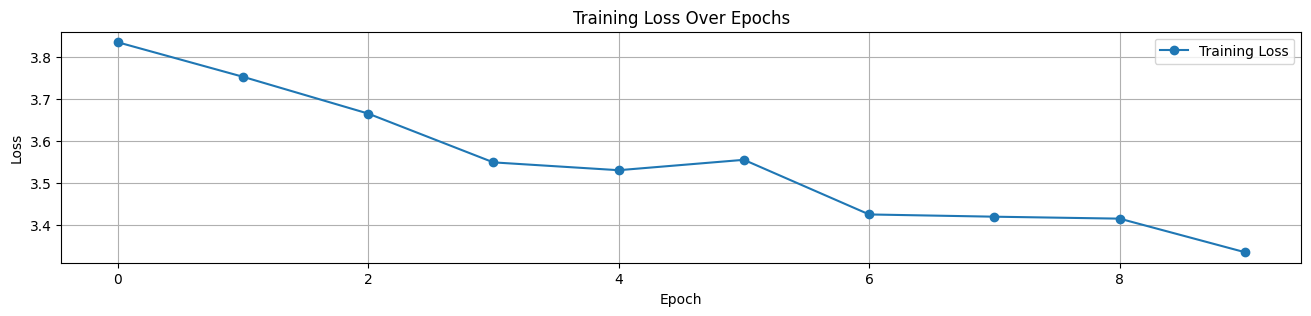

In [38]:
plt.figure(figsize=(16, 3))
plt.plot(loss_history, label='Training Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

Loss is decreasing but not as expected, there is a need to train for more epochs and tune the hyperparameters further, but my gpu isn't that great to run it with more epochs, so I will stop here for now, as i am just demonstrating the code structure and flow.

Now that we have trained the model, we can use it to generate videos from text prompts or images, this is our next step.

## Inferencing Veo 3 with Cascading Reverse Diffusion

We have trained our model for a few epochs. Although we have coded each component of the model, it is not complex enough to require a full training run. Still, we can use the training procedure to perform inference with our model, though we will see only noisy video and audio outputs, as the model is not trained on large-scale data yet.
    
But inferencing is not as easy as you think, as it requires some additional steps to prepare the inputs and process the outputs.

Inference is now a two-step process using cascaded reverse diffusion:
1. first, we generate the low-resolution base latents (video and audio), and then we use these generated base latents to condition the upsampler model, which refines the video to a higher resolution.
2. The logic remains the same for both text-to-video (T2V) and image-to-video (I2V) inference; if an image is provided, its embedding is added to the context for both the base and upsampler models.
3. Finally, the 'clean' high-resolution video latent and the base audio latent are passed through their respective VAE decoders.

Let's create that logic into a  `generate_content` function to show this two-stage reverse diffusion process.

In [39]:
INFERENCE_STEPS = 50 # Number of steps for inference denoising (the number of steps in the inference process)

def generate_content(prompt, input_image_path=None, steps=INFERENCE_STEPS):
    # Set all models to evaluation mode
    for m in [video_vae, audio_vae, base_denoiser, upsampler_denoiser, conditioning_encoder]:
        m.eval()
    with torch.no_grad():
        # --- 1. Prepare Conditioning ---
        # Get text embeddings for the prompt
        text_embeds = conditioning_encoder.get_text_embeds(prompt)
        context = text_embeds
        # If an input image is provided, get its embedding and add to context
        if input_image_path:
            img_pil = Image.open(input_image_path).convert("RGB").resize((BASE_VIDEO_WIDTH, BASE_VIDEO_HEIGHT))
            img_tensor = transforms.ToTensor()(img_pil).unsqueeze(0).to(DEVICE)
            context += conditioning_encoder.get_image_embeds(img_tensor)
        
        # --- 2. Base Generation Stage ---
        # Sample random noise for base video and audio latents
        vid_latents_base = torch.randn(1, VIDEO_LATENT_CHANNELS, VIDEO_LATENT_FRAMES, BASE_VIDEO_LATENT_H, BASE_VIDEO_LATENT_W, device=DEVICE)
        aud_latents = torch.randn(1, AUDIO_LATENT_CHANNELS, AUDIO_LATENT_SAMPLES, device=DEVICE)

        # Set the scheduler timesteps for inference
        noise_scheduler.set_timesteps(steps)
        # Denoising loop for base video and audio
        for t in tqdm(noise_scheduler.timesteps, desc="Denoising (Base)"):
            ts = t.unsqueeze(0).to(DEVICE)
            pred_vid_noise, pred_aud_noise = base_denoiser(vid_latents_base, aud_latents, ts, context)
            vid_latents_base = noise_scheduler.step(pred_vid_noise, t, vid_latents_base).prev_sample
            aud_latents = noise_scheduler.step(pred_aud_noise, t, aud_latents).prev_sample

        # --- 3. Upsampler Generation Stage ---
        # Sample random noise for upsampled video latents
        vid_latents_upsampled = torch.randn(1, VIDEO_LATENT_CHANNELS, VIDEO_LATENT_FRAMES, UPSAMPLED_VIDEO_LATENT_H, UPSAMPLED_VIDEO_LATENT_W, device=DEVICE)
        # Denoising loop for upsampled video, conditioned on clean base video latents
        for t in tqdm(noise_scheduler.timesteps, desc="Denoising (Upsampler)"):
            ts = t.unsqueeze(0).to(DEVICE)
            pred_vid_noise_up, _ = upsampler_denoiser(
                vid_latents_upsampled, torch.zeros_like(aud_latents), ts, context, low_res_video=vid_latents_base
            )
            vid_latents_upsampled = noise_scheduler.step(pred_vid_noise_up, t, vid_latents_upsampled).prev_sample
        
        # --- 4. Decode Final Latents ---
        # Decode the final video and audio latents to output
        final_video = video_vae.decode(vid_latents_upsampled)
        final_audio = audio_vae.decode(aud_latents)
        return final_video, final_audio

So, our `generate_content` function takes a text prompt and an optional input image path, and generates a video and audio content based on the provided prompt. It uses the trained models to denoise the latent representations step by step, first for the base resolution and then for the upsampled resolution.

Now we can use images or text prompts to generate videos. Let's test the text-to-video generation.

In [40]:
# Example: Generate a video and audio from a text prompt using the trained model
t2v_prompt = "A mystical forest with glowing trees and soft ethereal music."
gen_video_t2v, gen_audio_t2v = generate_content(t2v_prompt)

Denoising (Upsampler): 100%|██████████| 50/50 [00:00<00:00, 82.94it/s]


We need to visualize for that we can define a short function to display the generated video and audio.

--- Displaying Generated Outputs ---


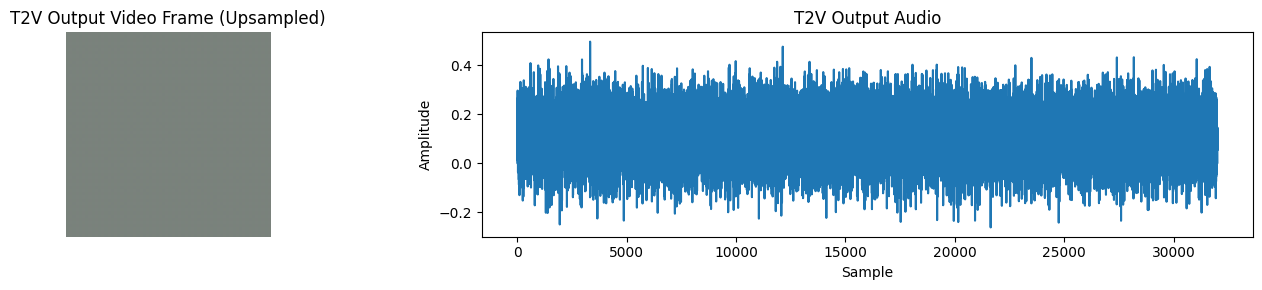

In [43]:
# This function displays a frame from the generated video and the waveform of the generated audio.
# - video: tensor of shape (B, C, F, H, W), displays the middle frame.
# - audio: tensor of shape (B, C, L), plots the waveform.
# - title_prefix: string to prefix the plot titles.

def display_media(video, audio, title_prefix=""):
    fig, axes = plt.subplots(1, 2, figsize=(15, 3))
    
    if video is not None:
        # Extract the middle frame from the upsampled video and display it
        frame = (video[0,:, BASE_VIDEO_FRAMES//2].permute(1,2,0).cpu().numpy()*255).astype(np.uint8)
        axes[0].imshow(frame)
        axes[0].set_title(f"{title_prefix} Video Frame (Upsampled)")
        axes[0].axis('off')
    
    if audio is not None:
        # Plot the audio waveform
        axes[1].plot(audio[0,0].cpu())
        axes[1].set_title(f"{title_prefix} Audio")
        axes[1].set_xlabel('Sample')
        axes[1].set_ylabel('Amplitude')
    
    plt.tight_layout()
    plt.show()

print("--- Displaying Generated Outputs ---")
display_media(gen_video_t2v, gen_audio_t2v, "T2V Output")

You can see the output frame of of our video is very noisy and the audio is just noise too, as I stated earlier we have trained a small scale model on a small dataset, so the results are not very good. However, you can see that the model is able to generate a video and audio from a text prompt, which is the main goal of this project.

But now comes an important question, we have our ugly veo 3 ready, how google evaluates the model performance? This is the next step in our project.

## Evaluation Strategy

Google didn't share the exact metrics they used, though they mentioned in their model card that `Veo v3` was evaluated on the MovieGenBench (video and video+audio) benchmark datasets released by Meta. These datasets consist of 1,003 prompts for video and 527 prompts for video+audio, along with respective videos generated by other models: Meta’s MovieGen (video and video+audio), Kling 2.0 (video only), Minimax (video only), and Sora Turbo (video only).

There are many benchmark datasets that can be used for evaluation, but if we talk about statistical evaluation, there are several ways this can be achieved. Two common metrics used for evaluating the quality of generated videos are:
1. CLIP Score: This metric uses the CLIP model to evaluate how well the generated video matches the text prompt. It computes the cosine similarity between the text embedding and the video frame embedding.
2. LPIPS (Learned Perceptual Image Patch Similarity): This metric measures the perceptual similarity between the generated video frame and a reference image, and is often used to evaluate the quality of generated images or videos.

These are the most commonly used metrics for evaluating the quality of generated videos, especially in the context of text-to-video generation tasks.

Let's create a function to calculate the CLIP score:


In [44]:
def calculate_clip_score(gen_video, prompt):

    # Extract the middle frame from the generated video and convert to PIL image
    middle_frame = gen_video[0, :, BASE_VIDEO_FRAMES // 2].cpu()
    frame_pil = transforms.ToPILImage()(middle_frame)
    
    # Get CLIP embeddings for the prompt and the frame
    text_embed = conditioning_encoder.get_text_embeds(prompt)
    image_embed = conditioning_encoder.get_image_embeds(frame_pil)
    
    # Normalize embeddings
    text_embed = text_embed / text_embed.norm(dim=-1, keepdim=True)
    image_embed = image_embed / image_embed.norm(dim=-1, keepdim=True)
    
    # Compute cosine similarity (CLIP score)
    clip_score = (text_embed @ image_embed.T).item()
    return clip_score

Our clip score function takes the generated video and a text prompt, extracts the middle frame from the video, computes CLIP embeddings for both the frame and the prompt, and returns the cosine similarity score as the CLIP score.
    
Similar for lpips, we will use the LPIPS metric to evaluate the perceptual similarity between the generated video frame and a reference image. we will use net='vgg' for the LPIPS model, which is a common choice for perceptual similarity tasks. `VGG` is a popular architecture for LPIPS due to its strong performance in capturing perceptual differences.

In [ ]:
# Try to install lpips here as it might affect your environment, its better to install it here with caution rather than in requirements.txt
# !pip install lpips --quiet

In [ ]:
try:
    import lpips
    lpips_available = True
except ImportError:
    lpips_available = False
    print("LPIPS not available. Skipping LPIPS score calculation.")

In [ ]:
# Instantiate the LPIPS model with VGG backbone and move to the configured device
if lpips_available:
    lpips_model = lpips.LPIPS(net='vgg').to(DEVICE)

def calculate_lpips(gen_video, img_path):

    # Load and preprocess the reference image: resize, convert to tensor, scale to [-1, 1]
    input_img = transforms.ToTensor()(
        Image.open(img_path).convert('RGB').resize(
            (UPSAMPLED_VIDEO_WIDTH, UPSAMPLED_VIDEO_HEIGHT)
        )
    ).unsqueeze(0) * 2 - 1

    # Extract and preprocess the first frame from the generated video, scale to [-1, 1]
    gen_frame = gen_video[0, :, 0].cpu().unsqueeze(0) * 2 - 1

    # Compute LPIPS score between the reference image and generated frame
    return lpips_model(input_img.to(DEVICE), gen_frame.to(DEVICE)).item()

In [47]:
# Calculate the CLIP score for the generated video and prompt.
# This measures how well the generated video matches the text prompt using CLIP embeddings.
clip_score = calculate_clip_score(gen_video_t2v, t2v_prompt)
print(f"T2V CLIP Score: {clip_score:.4f}")

T2V CLIP Score: 0.1389


So, our CLIP Score is close to `0`, which is very poor obviously, because training isn't done seriously, But this is a simple example to show how qualititative evaluation can be done on text to video generation models like `Veo 3` or `Video Diffusion Models`.

In the same way we can calculate the score of image to video or lpips score.

## Responsible AI & Safety Integration (Synth ID)

This section is purely in theory.

- **Safety First:** Veo 3 was built with help from safety and responsibility experts, following Google’s AI Principles.
- **Testing:** The model was tested in several ways:
    - **Development tests:** Done by the team to improve the model and check for responsible behavior.
    - **Assurance tests:** Done by a separate group for independent review and governance.
    - **Red teaming:** Specialists tried to find weaknesses and risks, both from inside and outside Google.
    - **Council review:** Google DeepMind’s safety council reviewed all results and helped decide if the model was safe to release.
- **System-level checks:** Extra safety checks are done when Veo 3 is used in real products.

**What They Found**

- **Content Safety:** Some issues were found (like policy violations or possible abuse), but these were fixed before launch. New tests and fixes are always being added.
- **Bias:** The model sometimes prefers lighter skin tones if race isn’t mentioned, and some words may be linked to certain groups unfairly. These issues are being studied and improved.
- **Other Risks:** No big risks found for hacking, self-replication, or dangerous uses (like chemicals or explosives). Veo 3 can make deepfakes, but they are lower quality than special deepfake tools, and watermarks can help detect them.

**Social Benefits**

- **Creativity:** Veo 3 makes it easier for anyone to create and edit videos, which can help with learning and creativity.
- **Research:** It can help researchers by making synthetic data for things like robotics and computer vision.

**Risks**

- **Misuse:** Someone could try to use Veo 3 on purpose to make harmful content.
- **Mistakes:** The model could make mistakes even if used normally.

**How Risks Are Reduced**

- **Before Training:** Harmful or duplicate videos were removed from the training data. Captions were added to make the data more diverse and fair.
- **After Training:** Tools like [SynthID](https://deepmind.google/science/synthid/) watermarking and filters are used to block or mark harmful outputs.

A very basic example of applying SynthID to AI-generated content is ...

In [ ]:
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    SynthIDTextWatermarkingConfig,
)

# Initialize the tokenizer and model from the Hugging Face Hub
tokenizer = AutoTokenizer.from_pretrained('repo/id')
model = AutoModelForCausalLM.from_pretrained('repo/id')

# Configure SynthID watermarking for text generation
watermarking_config = SynthIDTextWatermarkingConfig(
    keys=[654, 400, 836, 123, 340, 443, 597, 160, 57, ...],  # Replace ... with actual keys
    ngram_len=5,  # Length of n-grams to watermark
)

# Tokenize the input prompts
tokenized_prompts = tokenizer(["your prompts here"])

# Generate text with watermarking enabled
output_sequences = model.generate(
    **tokenized_prompts,
    watermarking_config=watermarking_config,
    do_sample=True,
)

# Decode the generated sequences back to text
watermarked_text = tokenizer.batch_decode(output_sequences)

## Conclusion

In this project, we have built a simplified version of Veo 3, a text-to-video generation model. We started by preprocessing the data, including deduplication, unsafe filtering, quality compliance checks, and data annotation. Then we designed the model architecture, including components like VideoVAE, AudioVAE, ConditioningEncoder, and JointDenoisingTransformer. Finally, we implemented the training loop and performed inference to generate videos from text prompts or images.

We also discussed the evaluation strategy, including CLIP and LPIPS scores, and touched on responsible AI practices and safety integration.

This project serves as a foundation for understanding how text-to-video generation models work and how to build them using PyTorch. While the model we built is not as powerful as Veo 3, it demonstrates the key concepts and components involved in such models.


Thank you [Google](https://deepmind.google/) for this [tech report](https://storage.googleapis.com/deepmind-media/veo/Veo-3-Tech-Report.pdf) and [model card](https://storage.googleapis.com/deepmind-media/Model-Cards/Veo-3-Model-Card.pdf).